# Team EDA Baseline (Full Data + R2 Download)

This notebook is the teammate-ready baseline for EDA on the full V1 merged dataset (no additional cleaning/feature engineering in this notebook).

Scope:
- Validate `scripts/r2.env` configuration
- Optionally run `scripts/download_from_r2.sh` to fetch `datasets/<DATASET_VERSION>/`
- Load full parquet partitions as a DuckDB view (`spotify_full`). Pandas is not possible because Dataset is too big for a full EDA.
- Run starter SQL EDA queries (shape, null rates, top regions/charts, yearly streams, audio feature summary)

## 1) Executive Summary

After we are done here: 

## 2) Load Project Dependencies and Paths

In [55]:
from pathlib import Path
import os
import re
import json
import textwrap
import subprocess
from typing import Dict, List, Tuple
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



In [56]:

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name != "Project_Information":
    for candidate in [Path.cwd(), *Path.cwd().parents]:
        if (candidate / "scripts").exists() and (candidate / "datasets").exists():
            NOTEBOOK_DIR = candidate / "Project_Information" if (candidate / "Project_Information").exists() else candidate
            break

REPO_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "Project_Information" else NOTEBOOK_DIR
SCRIPTS_DIR = REPO_ROOT / "scripts"
DEFAULT_DATASET_VERSION = "v1"
DEFAULT_DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DEFAULT_DATASET_VERSION
R2_ENV_PATH = SCRIPTS_DIR / "r2.env"
R2_ENV_EXAMPLE_PATH = SCRIPTS_DIR / "r2.env.example"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs" / "team_eda_baseline"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Scripts dir: {SCRIPTS_DIR}")
print(f"Default download root: {DEFAULT_DOWNLOAD_ROOT}")
print(f"R2 env file: {R2_ENV_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Repo root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB
Scripts dir: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/scripts
Default download root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
R2 env file: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/scripts/r2.env
Output dir: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/Project_Information/outputs/team_eda_baseline


## 3) Parse and Validate `scripts/r2.env` Configuration

In [2]:
REQUIRED_R2_KEYS = [
    "R2_ENDPOINT",
    "R2_BUCKET",
    "AWS_ACCESS_KEY_ID",
    "AWS_SECRET_ACCESS_KEY",
    "DATASET_VERSION",
]


def _strip_balanced_quotes(value: str) -> str:
    if len(value) >= 2 and ((value[0] == '"' and value[-1] == '"') or (value[0] == "'" and value[-1] == "'")):
        return value[1:-1]
    return value


def parse_env_file(env_path: Path) -> Tuple[Dict[str, str], List[str]]:
    parsed: Dict[str, str] = {}
    errors: List[str] = []

    if not env_path.exists():
        errors.append(f"Missing env file: {env_path}")
        return parsed, errors

    for line_no, raw_line in enumerate(env_path.read_text(encoding="utf-8").splitlines(), start=1):
        line = raw_line.strip()
        if not line or line.startswith("#"):
            continue
        if "=" not in line:
            errors.append(f"Line {line_no}: missing '=' separator")
            continue

        key, value = line.split("=", 1)
        key = key.strip()
        value = value.strip()

        if not re.fullmatch(r"[A-Za-z_][A-Za-z0-9_]*", key):
            errors.append(f"Line {line_no}: invalid key '{key}'")
            continue

        dbl_quote_count = value.count('"')
        sgl_quote_count = value.count("'")
        if dbl_quote_count % 2 != 0 or sgl_quote_count % 2 != 0:
            errors.append(
                f"Line {line_no}: malformed quotes for key '{key}' -> {value!r}"
            )
            continue

        normalized = _strip_balanced_quotes(value).strip()

        if normalized.endswith('"') or normalized.endswith("'"):
            errors.append(
                f"Line {line_no}: value for '{key}' appears to have a trailing quote -> {value!r}"
            )

        parsed[key] = normalized

    missing = [k for k in REQUIRED_R2_KEYS if not parsed.get(k)]
    if missing:
        errors.append(f"Missing required keys: {missing}")

    return parsed, errors


r2_config, r2_config_errors = parse_env_file(R2_ENV_PATH)

if r2_config_errors:
    print("r2.env validation failed:")
    for err in r2_config_errors:
        print(f"  - {err}")
    if R2_ENV_EXAMPLE_PATH.exists():
        print(f"\nTemplate available at: {R2_ENV_EXAMPLE_PATH}")
else:
    print("r2.env validation passed")
    display(pd.DataFrame([r2_config]).T.rename(columns={0: "value"}))

r2.env validation passed


,value
R2_ENDPOINT,https://a96b93c5d97cddb48fc674255fb687c7.r2.cl...
R2_BUCKET,ml-group-ab-datasets
AWS_ACCESS_KEY_ID,b4f318900453ff77a06d530e454aa330
AWS_SECRET_ACCESS_KEY,e196e275699090f32d71db4854983855b8b3fc05905a80...
DATASET_VERSION,v1


## 4) Implement Safe Environment Variable Export for Shell Commands

In [3]:
def build_sanitized_env(base_env: Dict[str, str], overrides: Dict[str, str] | None = None) -> Dict[str, str]:
    if r2_config_errors:
        raise ValueError("Cannot build environment: r2.env is invalid.")

    env = dict(os.environ)
    for key in REQUIRED_R2_KEYS:
        env[key] = str(base_env[key]).strip()

    if overrides:
        for k, v in overrides.items():
            if v is not None:
                env[k] = str(v)

    return env


def run_bash_script(script_path: Path, env: Dict[str, str], cwd: Path, timeout: int = 3600) -> subprocess.CompletedProcess:
    if not script_path.exists():
        raise FileNotFoundError(f"Missing script: {script_path}")

    cmd = ["bash", str(script_path)]
    result = subprocess.run(
        cmd,
        cwd=str(cwd),
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
    )

    print("--- stdout ---")
    print(result.stdout[-4000:] if result.stdout else "<empty>")
    print("--- stderr ---")
    print(result.stderr[-4000:] if result.stderr else "<empty>")
    print(f"Exit code: {result.returncode}")

    if result.returncode != 0:
        raise RuntimeError(
            "Download script failed. Check stdout/stderr above. "
            "For permission-related preflight errors, try SKIP_R2_PREFLIGHT=1."
        )

    return result

print("Shell helper ready")

Shell helper ready


## 5) Run Dataset Download Script

This cell is safe by default (`RUN_DOWNLOAD = False`). Set it to `True` when ready.

In [4]:
DOWNLOAD_SCRIPT = SCRIPTS_DIR / "download_from_r2.sh"
DATASET_VERSION = r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION) if not r2_config_errors else DEFAULT_DATASET_VERSION
DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DATASET_VERSION

RUN_DOWNLOAD = False  # modify to False to skip actual download

print(f"Default DATASET_VERSION: {DATASET_VERSION}")
print(f"Default DOWNLOAD_ROOT: {DOWNLOAD_ROOT}")

if RUN_DOWNLOAD:
    env_default = build_sanitized_env(
        r2_config,
        overrides={
            "DATASET_VERSION": DATASET_VERSION,
            "DOWNLOAD_ROOT": str(DOWNLOAD_ROOT),
        },
    )
    run_bash_script(DOWNLOAD_SCRIPT, env=env_default, cwd=REPO_ROOT)
else:
    print("Skipped default run. Set RUN_DOWNLOAD=True to execute.")

Default DATASET_VERSION: v1
Default DOWNLOAD_ROOT: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
Skipped default run. Set RUN_DOWNLOAD=True to execute.


## 6) Load Parquet as DuckDB View (No Full In-Memory DataFrame)

In [5]:
if "DOWNLOAD_ROOT" not in globals():
    fallback_version = (
        r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION)
        if "r2_config" in globals() and "DEFAULT_DATASET_VERSION" in globals()
        else "v1"
    )
    DOWNLOAD_ROOT = REPO_ROOT / "datasets" / fallback_version

active_download_root = DOWNLOAD_ROOT
full_root = active_download_root / "full"
if not full_root.exists():
    raise FileNotFoundError(f"Full dataset folder not found: {full_root}")

parquet_files = sorted(full_root.rglob("*.parquet"))
if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under: {full_root}")

print(f"Active download root: {active_download_root}")
print(f"Total parquet files in full dataset: {len(parquet_files)}")

try:
    import duckdb
except ImportError as exc:
    raise ImportError(
        "duckdb is required for SQL-based EDA. Install it with: pip install duckdb"
    ) from exc

con = duckdb.connect(database=":memory:")
parquet_glob = (full_root / "year=*" / "*.parquet").as_posix()

con.execute(
    f"""
    CREATE OR REPLACE VIEW spotify_full AS
    SELECT *
    FROM read_parquet('{parquet_glob}', hive_partitioning = true);
    """
)


Active download root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
Total parquet files in full dataset: 24


# Exploratory Data Analyis

## 7. Dataset Overview and Quality Assessment

### 7.1 Variable Types

In [72]:
print("=" * 65)
print("  DATASET OVERVIEW — spotify_full")
print("=" * 65)

# 1. Total rows & columns 
row_count = con.execute("SELECT COUNT(*) FROM spotify_full").fetchone()[0]
schema_df = con.execute("DESCRIBE spotify_full").df()
print(f"\n  Rows   : {row_count:>12,}")
print(f"  Columns: {len(schema_df):>12}")

# 2. Schema — column name + data type 
print("\n── Columns ────────────────────────────────────────────────────")
print(f"  {'#':<4} {'Column':<35} {'Type'}")
print(f"  {'-'*4} {'-'*35} {'-'*15}")
for i, row in schema_df.iterrows():
    print(f"  {i+1:<4} {row['column_name']:<35} {row['column_type']}")

# 3. Date / time coverage
date_range = con.execute("""
    SELECT
        MIN(year)  AS year_min,
        MAX(year)  AS year_max,
        COUNT(DISTINCT year) AS n_years
    FROM spotify_full
""").df()
print("\n── Time Coverage ──────────────────────────────────────────────")
print(f"  Years covered : {int(date_range['year_min'][0])} – {int(date_range['year_max'][0])}")
print(f"  Distinct years: {int(date_range['n_years'][0])}")

# 4. Key categorical counts
counts = con.execute("""
    SELECT
        COUNT(DISTINCT region)           AS n_regions,
        COUNT(DISTINCT chart)            AS n_chart_types,
        COUNT(DISTINCT track_id)         AS n_unique_tracks,
        COUNT(DISTINCT artist)           AS n_unique_artists
    FROM spotify_full
""").df()

print("\n── Key Counts ─────────────────────────────────────────────────")
for col in counts.columns:
    print(f"  {col:<30}: {int(counts[col][0]):>10,}")

# 5. Sample rows 
print("\n── Sample Rows (5) ────────────────────────────────────────────")
sample = con.execute("""
    SELECT date, region, chart, rank,
           track_id, artist,
           TRY_CAST(streams AS BIGINT) AS streams,
           year
    FROM spotify_full
    LIMIT 5
""").df()
display(sample)

# 6. Plain-English description 
description = """
What is this dataset?
  Each row represents one song's chart entry for a given date, chart type,
  and country/region. It captures the Spotify Top 200 (and Viral 50) charts
  globally, recorded daily.

Key columns at a glance:
  date / year       – when the chart entry was recorded
  region            – country or 'global' the chart belongs to
  chart             – chart type, 'top200' or 'viral50'
  rank              – position on that chart (1 = #1 song)
  track_name        – song title
  artist            – performing artist(s)
  streams           – number of streams on that day for that song/region
  track_id          – Spotify track URI (unique per song)
  af_*              – Spotify Audio Features (danceability, energy, valence,
                      tempo, loudness, acousticness, speechiness,
                      instrumentalness, liveness)
  popularity        – Spotify popularity score (0–100) at time of entry
  explicit          – whether the track contains explicit content
  country_continent – continent derived from region (engineered feature)
"""
print(textwrap.dedent(description))
print("=" * 65)

  DATASET OVERVIEW — spotify_full

  Rows   :   26,174,269
  Columns:           46

── Columns ────────────────────────────────────────────────────
  #    Column                              Type
  ---- ----------------------------------- ---------------
  1    title                               VARCHAR
  2    rank                                VARCHAR
  3    date                                VARCHAR
  4    artist                              VARCHAR
  5    url                                 VARCHAR
  6    region                              VARCHAR
  7    chart                               VARCHAR
  8    trend                               VARCHAR
  9    streams                             VARCHAR
  10   track_id                            VARCHAR
  11   album                               VARCHAR
  12   popularity                          VARCHAR
  13   duration_ms                         VARCHAR
  14   explicit                            VARCHAR
  15   release_date            

,date,region,chart,rank,track_id,artist,streams,year
0,2017-01-01,Argentina,top200,1,6mICuAdrwEjh6Y6lroV2Kg,Shakira,253019,2017
1,2017-01-01,Argentina,top200,2,7DM4BPaS7uofFul3ywMe46,Ricky Martin,223988,2017
2,2017-01-01,Argentina,top200,3,3AEZUABDXNtecAOSC1qTfo,CNCO,210943,2017
3,2017-01-01,Argentina,top200,4,6rQSrBHf7HlZjtcMZ4S4bO,"J Balvin, Pharrell Williams, BIA, Sky",173865,2017
4,2017-01-01,Argentina,top200,5,58IL315gMSTD37DOZPJ2hf,Daddy Yankee,153956,2017



What is this dataset?
  Each row represents one song's chart entry for a given date, chart type,
  and country/region. It captures the Spotify Top 200 (and Viral 50) charts
  globally, recorded daily.

Key columns at a glance:
  date / year       – when the chart entry was recorded
  region            – country or 'global' the chart belongs to
  chart             – chart type, 'top200' or 'viral50'
  rank              – position on that chart (1 = #1 song)
  track_name        – song title
  artist            – performing artist(s)
  streams           – number of streams on that day for that song/region
  track_id          – Spotify track URI (unique per song)
  af_*              – Spotify Audio Features (danceability, energy, valence,
                      tempo, loudness, acousticness, speechiness,
                      instrumentalness, liveness)
  popularity        – Spotify popularity score (0–100) at time of entry
  explicit          – whether the track contains explicit content


,chart,row_count,pct_rows
0,top200,20321961,77.64
1,viral50,5852308,22.36


Global vs local row share:


,scope,row_count,pct_rows
0,local,25722465,98.27
1,global,451804,1.73


Chart mix by year (row counts):


chart,top200,viral50
year,,
2017,3386564,1015273
2018,3739327,1123728
2019,4210217,1202469
2020,4550811,1242344
2021,4435042,1268494


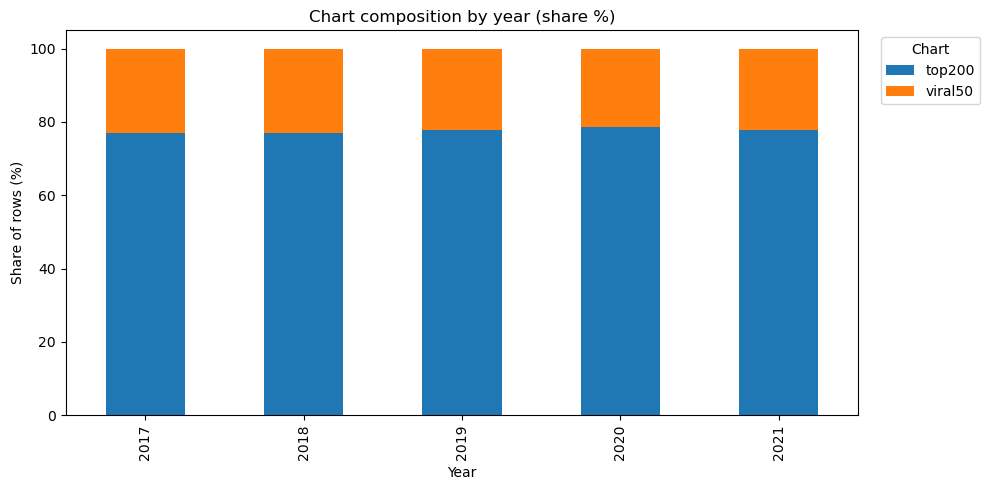

In [73]:
# 3.3 Chart composition
chart_mix_df = con.execute("""
SELECT
    chart,
    COUNT(*) AS row_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct_rows
FROM spotify_full
GROUP BY chart
ORDER BY row_count DESC;
""").df()

display(chart_mix_df)

global_share_df = con.execute("""
SELECT
    CASE WHEN LOWER(region) = 'global' THEN 'global' ELSE 'local' END AS scope,
    COUNT(*) AS row_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct_rows
FROM spotify_full
GROUP BY 1
ORDER BY row_count DESC;
""").df()

print("Global vs local row share:")
display(global_share_df)

chart_mix_by_year_df = con.execute("""
WITH y AS (
    SELECT
        CASE
            WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN TRY_CAST(year AS INTEGER)
            ELSE EXTRACT(YEAR FROM TRY_CAST(date AS DATE))::INTEGER
        END AS year_val,
        chart
    FROM spotify_full
)
SELECT
    year_val AS year,
    chart,
    COUNT(*) AS row_count
FROM y
WHERE year_val IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2;
""").df()

chart_mix_year_pivot = chart_mix_by_year_df.pivot(index="year", columns="chart", values="row_count").fillna(0).sort_index()
chart_mix_year_share = chart_mix_year_pivot.div(chart_mix_year_pivot.sum(axis=1), axis=0) * 100

print("Chart mix by year (row counts):")
display(chart_mix_year_pivot.astype(int))

ax = chart_mix_year_share.plot(kind="bar", stacked=True, figsize=(10, 5))
ax.set_title("Chart composition by year (share %)")
ax.set_xlabel("Year")
ax.set_ylabel("Share of rows (%)")
plt.legend(title="Chart", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 7.2 Missing values


In [74]:
null_rows = []
for col in schema_df["column_name"].tolist():
    # Quote identifiers safely for DuckDB
    col_quoted = f'"{col}"'
    q = f"""SELECT '{col}' AS column_name,
                    AVG(CASE WHEN {col_quoted} IS NULL THEN 1.0 ELSE 0.0 END) AS null_rate
             FROM spotify_full"""
    null_rows.append(con.execute(q).df())

null_df = pd.concat(null_rows, ignore_index=True).sort_values("null_rate", ascending=False)
print("\nMissingness (top 15 by null rate):")
display(null_df.head(15))


Missingness (top 15 by null rate):


,column_name,null_rate
8,streams,0.223590
45,index,0.193528
44,cultural_top5_targets,0.193528
43,cultural_distance_count,0.193528
42,cultural_distance_max,0.193528
41,cultural_distance_min,0.193528
40,cultural_distance_median,0.193528
39,cultural_distance_mean,0.193528
33,country_population,0.034378
38,country_driving_side,0.034378


In [75]:
# ── Count entries with 0 or NULL streams ─────────────────────────────────────
stream_quality = con.execute("""
    SELECT
        COUNT(*)                                                          AS total_rows,
        SUM(CASE WHEN streams IS NULL THEN 1 ELSE 0 END)                 AS null_streams,
        SUM(CASE WHEN streams IS NULL
                  OR TRY_CAST(streams AS DOUBLE) = 0 THEN 1 ELSE 0 END)  AS null_or_zero_streams
    FROM spotify_full

""").df()

total = stream_quality["total_rows"][0]
null_s  = stream_quality["null_streams"][0]
valid_s = total-null_s

print("═" * 50)
print("  STREAMS — NULL / ZERO ENTRY COUNT")
print("═" * 50)
print(f"  Total rows          : {total:>12,} ({total/total*100:.2f}%)")
print(f"  NULL streams        : {null_s:>12,}  ({null_s/total*100:.2f}%)")
print(f"Total valid stream    : {valid_s:> 12,} ({valid_s/total*100:.2f}%)")

print("═" * 50)


══════════════════════════════════════════════════
  STREAMS — NULL / ZERO ENTRY COUNT
══════════════════════════════════════════════════
  Total rows          :   26,174,269 (100.00%)
  NULL streams        :  5,852,308.0  (22.36%)
Total valid stream    :  20,321,961.0 (77.64%)
══════════════════════════════════════════════════


In [76]:
# ── Count entries with zero missing values (complete rows) ───────────────────
schema_df = con.execute("DESCRIBE spotify_full").df()
all_cols  = schema_df["column_name"].tolist()

# Build a CASE expression that counts NULLs across all columns per row
null_count_expr = " + ".join(
    [f"CASE WHEN \"{c}\" IS NULL THEN 1 ELSE 0 END" for c in all_cols]
)

completeness = con.execute(f"""
    SELECT
        COUNT(*)                                                      AS total_rows,
        SUM(CASE WHEN ({null_count_expr}) = 0 THEN 1 ELSE 0 END)     AS complete_rows,
        SUM(CASE WHEN ({null_count_expr}) > 0 THEN 1 ELSE 0 END)     AS rows_with_any_null,
        AVG(CASE WHEN ({null_count_expr}) = 0 THEN 1.0 ELSE 0.0 END) AS complete_rate
    FROM spotify_full
""").df()

total    = int(completeness["total_rows"][0])
complete = int(completeness["complete_rows"][0])
any_null = int(completeness["rows_with_any_null"][0])
rate     = float(completeness["complete_rate"][0])

print("═" * 55)
print("  ROW COMPLETENESS — zero missing values")
print("═" * 55)
print(f"  Total rows              : {total:>12,}")
print(f"  Complete rows (0 nulls) : {complete:>12,}  ({rate*100:.2f}%)")
print(f"  Rows with ≥1 null       : {any_null:>12,}  ({(1-rate)*100:.2f}%)")
print("═" * 55)

# ── Breakdown: how many nulls per row (distribution) ─────────────────────────
print("\n── Distribution of null-count-per-row ────────────────────────")
null_dist = con.execute(f"""
    SELECT
        ({null_count_expr}) AS n_nulls_in_row,
        COUNT(*)             AS n_rows
    FROM spotify_full
    GROUP BY n_nulls_in_row
    ORDER BY n_nulls_in_row
""").df()
display(null_dist)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

═══════════════════════════════════════════════════════
  ROW COMPLETENESS — zero missing values
═══════════════════════════════════════════════════════
  Total rows              :   26,174,269
  Complete rows (0 nulls) :   16,423,650  (62.75%)
  Rows with ≥1 null       :    9,750,619  (37.25%)
═══════════════════════════════════════════════════════

── Distribution of null-count-per-row ────────────────────────


,n_nulls_in_row,n_rows
0,0,16423650
1,1,4428366
2,2,2601
3,3,4
4,7,3159976
5,8,962274
6,9,554
7,14,719359
8,15,173128
9,16,106


Integrated country diagnostics (top 25 by missing days):


,region,first_seen,last_seen,chart_rows,active_days,expected_days,missing_days,missing_days_pct,avg_streams,median_streams,total_streams
69,South Korea,2021-02-01,2021-12-31,76276,334,1826,1492,81.71,2687.430431,1826.0,1.600042e+08
66,Russia,2020-07-14,2021-12-31,126837,536,1826,1290,70.65,21099.099929,16537.5,2.124933e+09
65,Ukraine,2020-07-14,2021-12-31,127544,536,1826,1290,70.65,4333.549126,3432.0,4.366094e+08
55,India,2019-02-26,2021-12-31,253036,1040,1826,786,43.04,47457.710627,39744.0,9.554756e+09
58,Saudi Arabia,2018-11-19,2021-12-31,231649,1136,1826,690,37.79,3254.551647,2419.0,5.693740e+08
62,Morocco,2018-11-19,2021-12-31,191537,1136,1826,690,37.79,3088.643339,2133.0,4.164541e+08
64,Egypt,2018-11-19,2021-12-31,180469,1136,1826,690,37.79,2551.200398,1936.0,3.157468e+08
60,United Arab Emirates,2018-11-15,2021-12-31,198944,1140,1826,686,37.57,2147.140823,1649.0,3.050035e+08
52,Vietnam,2018-03-14,2021-12-31,312426,1389,1826,437,23.93,5695.451309,4076.0,1.387566e+09
50,Israel,2018-03-14,2021-12-31,330046,1389,1826,437,23.93,4703.704607,3805.0,1.230541e+09


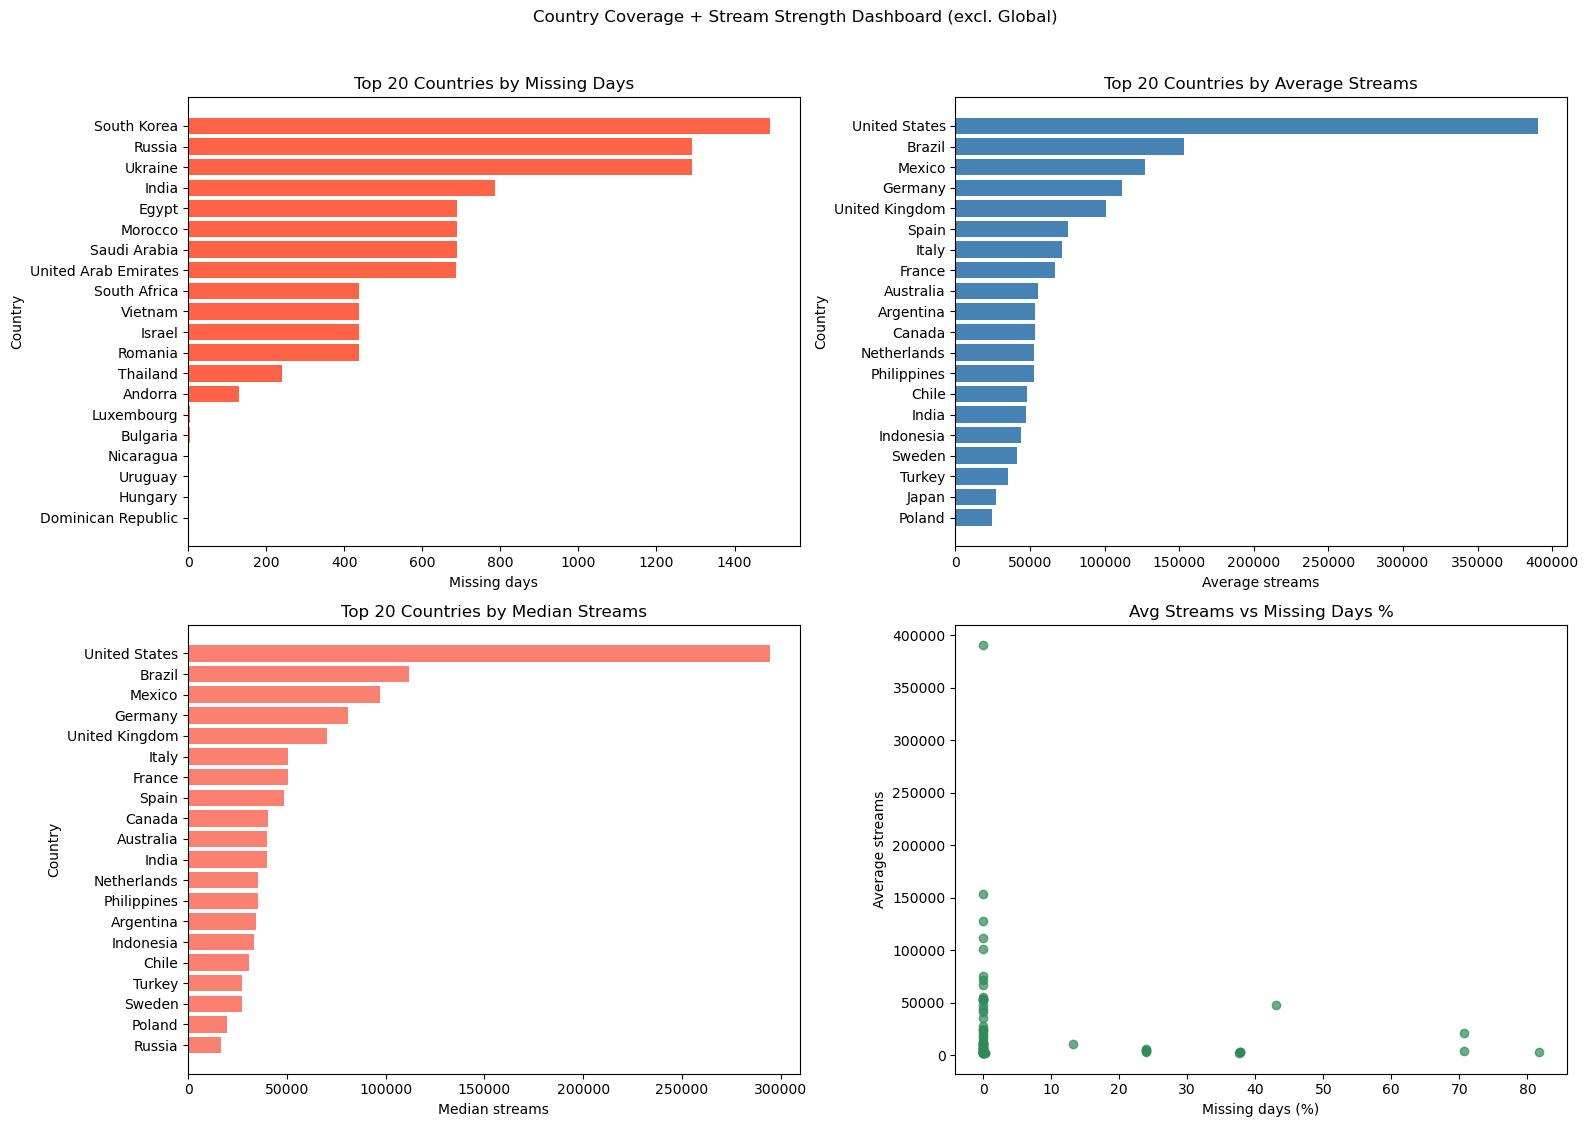

In [77]:
coverage_by_country_df = con.execute("""
WITH base AS (
    SELECT
        region,
        COALESCE(
            TRY_CAST(date AS DATE),
            CASE
                WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1)
                ELSE NULL
            END
        ) AS event_date
    FROM spotify_full
    WHERE region IS NOT NULL
)
SELECT
    region,
    COUNT(*) AS chart_rows,
    COUNT(DISTINCT event_date) AS active_days,
    MIN(event_date) AS first_seen,
    MAX(event_date) AS last_seen
FROM base
WHERE event_date IS NOT NULL
GROUP BY region
ORDER BY chart_rows DESC;
""").df()
# 3.2.1 Integrated country diagnostics table + dashboard
country_stream_stats_df = con.execute("""
SELECT
    region,
    COUNT(*) AS n_entries,
    AVG(TRY_CAST(streams AS DOUBLE)) AS avg_streams,
    MEDIAN(TRY_CAST(streams AS DOUBLE)) AS median_streams,
    MAX(TRY_CAST(streams AS BIGINT)) AS max_streams,
    SUM(TRY_CAST(streams AS BIGINT)) AS total_streams
FROM spotify_full
WHERE streams IS NOT NULL
  AND track_id IS NOT NULL
  AND region IS NOT NULL
GROUP BY region;
""").df()

missing_days_by_country_df = con.execute("""
WITH date_bounds AS (
    SELECT
        MIN(COALESCE(
            TRY_CAST(date AS DATE),
            CASE WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1) END
        )) AS min_date,
        MAX(COALESCE(
            TRY_CAST(date AS DATE),
            CASE WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1) END
        )) AS max_date
    FROM spotify_full
),
country_activity AS (
    SELECT
        region,
        COUNT(DISTINCT COALESCE(
            TRY_CAST(date AS DATE),
            CASE WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1) END
        )) AS active_days
    FROM spotify_full
    WHERE region IS NOT NULL
    GROUP BY region
)
SELECT
    ca.region,
    db.min_date,
    db.max_date,
    DATE_DIFF('day', db.min_date, db.max_date) + 1 AS expected_days,
    ca.active_days,
    (DATE_DIFF('day', db.min_date, db.max_date) + 1) - ca.active_days AS missing_days,
    ROUND(
        100.0 * ((DATE_DIFF('day', db.min_date, db.max_date) + 1) - ca.active_days)
        / (DATE_DIFF('day', db.min_date, db.max_date) + 1),
        2
    ) AS missing_days_pct
FROM country_activity ca
CROSS JOIN date_bounds db;
""").df()

country_diagnostics_df = (
    coverage_by_country_df
    .merge(missing_days_by_country_df[["region", "expected_days", "missing_days", "missing_days_pct"]], on="region", how="left")
    .merge(country_stream_stats_df, on="region", how="left")
)

# Exclude global for country-comparison views
country_diagnostics_no_global_df = country_diagnostics_df[
    country_diagnostics_df["region"].str.lower() != "global"
].copy()

# Neat summary table (most relevant fields)
country_diagnostics_display_df = country_diagnostics_no_global_df[[
    "region", "first_seen", "last_seen", "chart_rows", "active_days", "expected_days", "missing_days", "missing_days_pct",
    "avg_streams", "median_streams", "total_streams"
]].sort_values(["missing_days", "avg_streams"], ascending=[False, False])

print("Integrated country diagnostics (top 25 by missing days):")
display(country_diagnostics_display_df.head(25))

# ---- Graph dashboard ----
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# 1) Missing days (top 20)
plot_missing = country_diagnostics_no_global_df.sort_values("missing_days", ascending=False).head(20)
axes[0, 0].barh(plot_missing["region"][::-1], plot_missing["missing_days"][::-1], color="tomato")
axes[0, 0].set_title("Top 20 Countries by Missing Days")
axes[0, 0].set_xlabel("Missing days")
axes[0, 0].set_ylabel("Country")

# 2) Average streams (top 20)
plot_avg = country_diagnostics_no_global_df.sort_values("avg_streams", ascending=False).head(20)
axes[0, 1].barh(plot_avg["region"][::-1], plot_avg["avg_streams"][::-1], color="steelblue")
axes[0, 1].set_title("Top 20 Countries by Average Streams")
axes[0, 1].set_xlabel("Average streams")
axes[0, 1].set_ylabel("Country")

# 3) Median streams (top 20)
plot_median = country_diagnostics_no_global_df.sort_values("median_streams", ascending=False).head(20)
axes[1, 0].barh(plot_median["region"][::-1], plot_median["median_streams"][::-1], color="salmon")
axes[1, 0].set_title("Top 20 Countries by Median Streams")
axes[1, 0].set_xlabel("Median streams")
axes[1, 0].set_ylabel("Country")

# 4) Data completeness vs stream strength
axes[1, 1].scatter(
    country_diagnostics_no_global_df["missing_days_pct"],
    country_diagnostics_no_global_df["avg_streams"],
    alpha=0.7,
    color="seagreen"
)
axes[1, 1].set_title("Avg Streams vs Missing Days %")
axes[1, 1].set_xlabel("Missing days (%)")
axes[1, 1].set_ylabel("Average streams")

plt.suptitle("Country Coverage + Stream Strength Dashboard (excl. Global)", y=1.02)
plt.tight_layout()
plt.show()

In [78]:

# ── One sample entry per distinct null-count group — displayed side by side ───
# Collect one sample row per group, then concatenate into a wide comparison table.

samples = {}

for n_nulls in null_dist["n_nulls_in_row"].tolist():
    n_rows = int(null_dist.loc[null_dist["n_nulls_in_row"] == n_nulls, "n_rows"].values[0])

    row = con.execute(f"""
        SELECT *
        FROM spotify_full
        WHERE ({null_count_expr}) = {n_nulls}
        LIMIT 1
    """).df().iloc[0]

    col_label = f"{n_nulls} nulls\n({n_rows:,} rows)"
    samples[col_label] = row

# Build wide DataFrame: rows = columns of spotify_full, columns = null-count groups
wide = pd.DataFrame(samples)

# Highlight null cells in red
def highlight_nulls(df):
    return df.map(lambda v: "background-color: #ffcccc; color: #cc0000" if pd.isna(v) else "")

display(
    wide.style
    .apply(highlight_nulls, axis=None)
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "11px"), ("text-align", "center"), ("white-space", "pre-wrap")]},
        {"selector": "td", "props": [("font-size", "10px"), ("max-width", "160px"),
                                      ("overflow", "hidden"), ("text-overflow", "ellipsis"),
                                      ("white-space", "nowrap")]},
    ])
    .set_caption("Sample entry per null-count group — red cells are NULL")
)


RuntimeError: Query interrupted

Not all countries have cultural distance measures, these countries can be removed. 

### 7.3 Duplicates

In [ ]:
# Check for duplicate entries (same song, country, date, chart)
print("  DUPLICATE CHECK — (track_id, region, date, chart)")
print("═" * 60)

# 1. Total rows vs distinct combinations
totals = con.execute("""
    SELECT
        COUNT(*) AS total_rows,
        COUNT(DISTINCT (track_id, region, date, chart)) AS distinct_combinations
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
""").df()

total     = int(totals["total_rows"][0])
distinct  = int(totals["distinct_combinations"][0])
dupes     = total - distinct

print(f"\n  Total rows (excl. NULL streams/track_id) : {total:>12,}")
print(f"  Distinct combinations                    : {distinct:>12,}")
print(f"  Duplicate rows                           : {dupes:>12,}  ({dupes/total*100:.2f}%)")

# 2. Top 20 most duplicated combinations
print("\n── Top 20 most duplicated (track_id, region, date, chart) ──")
top_dupes = con.execute("""
    SELECT
        track_id,
        region,
        date,
        chart,
        COUNT(*) AS n_entries,
        MIN(TRY_CAST(streams AS BIGINT)) AS streams_min,
        MAX(TRY_CAST(streams AS BIGINT)) AS streams_max
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
    GROUP BY track_id, region, date, chart
    HAVING COUNT(*) > 1
    ORDER BY n_entries DESC
""").df()

if top_dupes.empty:
    print("No duplicates found!")
else:
    print(f"{len(top_dupes):,} duplicate groups found (showing top 20)")
    display(top_dupes)

# 3. Are stream values identical across duplicates, or do they differ?
print("\n── Do duplicate rows have conflicting stream values? ────────")
conflict_check = con.execute("""
    SELECT
        COUNT(*) AS groups_with_conflicting_streams
    FROM (
        SELECT track_id, region, date, chart
        FROM spotify_full
        WHERE streams IS NOT NULL
          AND track_id IS NOT NULL
        GROUP BY track_id, region, date, chart
        HAVING COUNT(*) > 1
          AND MIN(TRY_CAST(streams AS BIGINT)) != MAX(TRY_CAST(streams AS BIGINT))
    )
""").fetchone()[0]

if conflict_check == 0:
    print("All duplicate rows have identical stream values (safe to deduplicate).")
else:
    print(f"{conflict_check:,} groups have DIFFERENT stream values — inspect before dropping!")

  DUPLICATE CHECK — (track_id, region, date, chart)
════════════════════════════════════════════════════════════

  Total rows (excl. NULL streams/track_id) :   20,318,921
  Distinct combinations                    :   20,318,864
  Duplicate rows                           :           57  (0.00%)

── Top 20 most duplicated (track_id, region, date, chart) ──


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

57 duplicate groups found (showing top 20)


,track_id,region,date,chart,n_entries,streams_min,streams_max
0,4hGyLmElEHdBf29ubQ61Yq,Peru,2018-06-16,top200,2,7502,7502
1,3JGE1pWIf4Z6JqjIz6f1F4,Germany,2017-09-04,top200,2,39925,39925
2,7mIFzHyC5luAXh0jIMj6XY,Taiwan,2017-09-02,top200,2,2662,2662
3,7mIFzHyC5luAXh0jIMj6XY,Singapore,2017-09-01,top200,2,6455,6455
4,3JGE1pWIf4Z6JqjIz6f1F4,Austria,2017-09-01,top200,2,2627,2627
5,5RwZ97IdwhGxQWsvSXBokl,Paraguay,2017-09-01,top200,2,2117,2117
6,3al2hpm92xE0pBalqWQHdD,United States,2017-10-17,top200,2,172563,172563
7,6w40GgWhGts8g6779DPXR3,Israel,2018-03-20,top200,2,1006,1006
8,6w40GgWhGts8g6779DPXR3,Israel,2018-03-18,top200,2,1093,1093
9,3ZVrELQ8ncJNY0K6oWgHSB,Singapore,2017-09-01,top200,2,3917,3917



── Do duplicate rows have conflicting stream values? ────────


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

All duplicate rows have identical stream values (safe to deduplicate).


### 7.4 Snapshot and Example Entries

In [ ]:
TRACK_ID = "6mICuAdrwEjh6Y6lroV2Kg"

all_entries = con.execute(f"""
    SELECT title, date, track_id, region, chart, artist,
           TRY_CAST(streams AS BIGINT) AS streams,
           year
    FROM spotify_full
    WHERE track_id = '{TRACK_ID}'
      AND date = '2017-02-04'
    ORDER BY streams DESC
    LIMIT 10
""").df()

print(f"Total entries found for track, this is with the limit: {len(all_entries):,}")
display(all_entries)

Total entries found for track, this is with the limit: 10


,title,date,track_id,region,chart,artist,streams,year
0,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Global,top200,Shakira,2525024,2017
1,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Mexico,top200,Shakira,392920,2017
2,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,United States,top200,Shakira,335450,2017
3,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Spain,top200,Shakira,283435,2017
4,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Germany,top200,Shakira,184731,2017
5,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Argentina,top200,Shakira,179411,2017
6,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Brazil,top200,Shakira,152974,2017
7,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Chile,top200,Shakira,129493,2017
8,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,France,top200,Shakira,94284,2017
9,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Netherlands,top200,Shakira,87131,2017


In [ ]:
# Total streams across all countries (excluding global) 
total_streams = con.execute(f"""
    SELECT SUM(TRY_CAST(streams AS BIGINT)) AS total_streams
    FROM spotify_full
    WHERE track_id = '{TRACK_ID}'
      AND date = '2017-02-04'
      AND LOWER(region) != 'global'
""").fetchone()[0]

print(f"Total streams for track '{TRACK_ID}' on 2017-02-04 (excl. global): {total_streams:,}")

Total streams for track '6mICuAdrwEjh6Y6lroV2Kg' on 2017-02-04 (excl. global): 2,520,622


The spotify top 200 global list streams is roughly an aggregation of all other countries top 200 streams.

### 7.5 Spread of streams

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

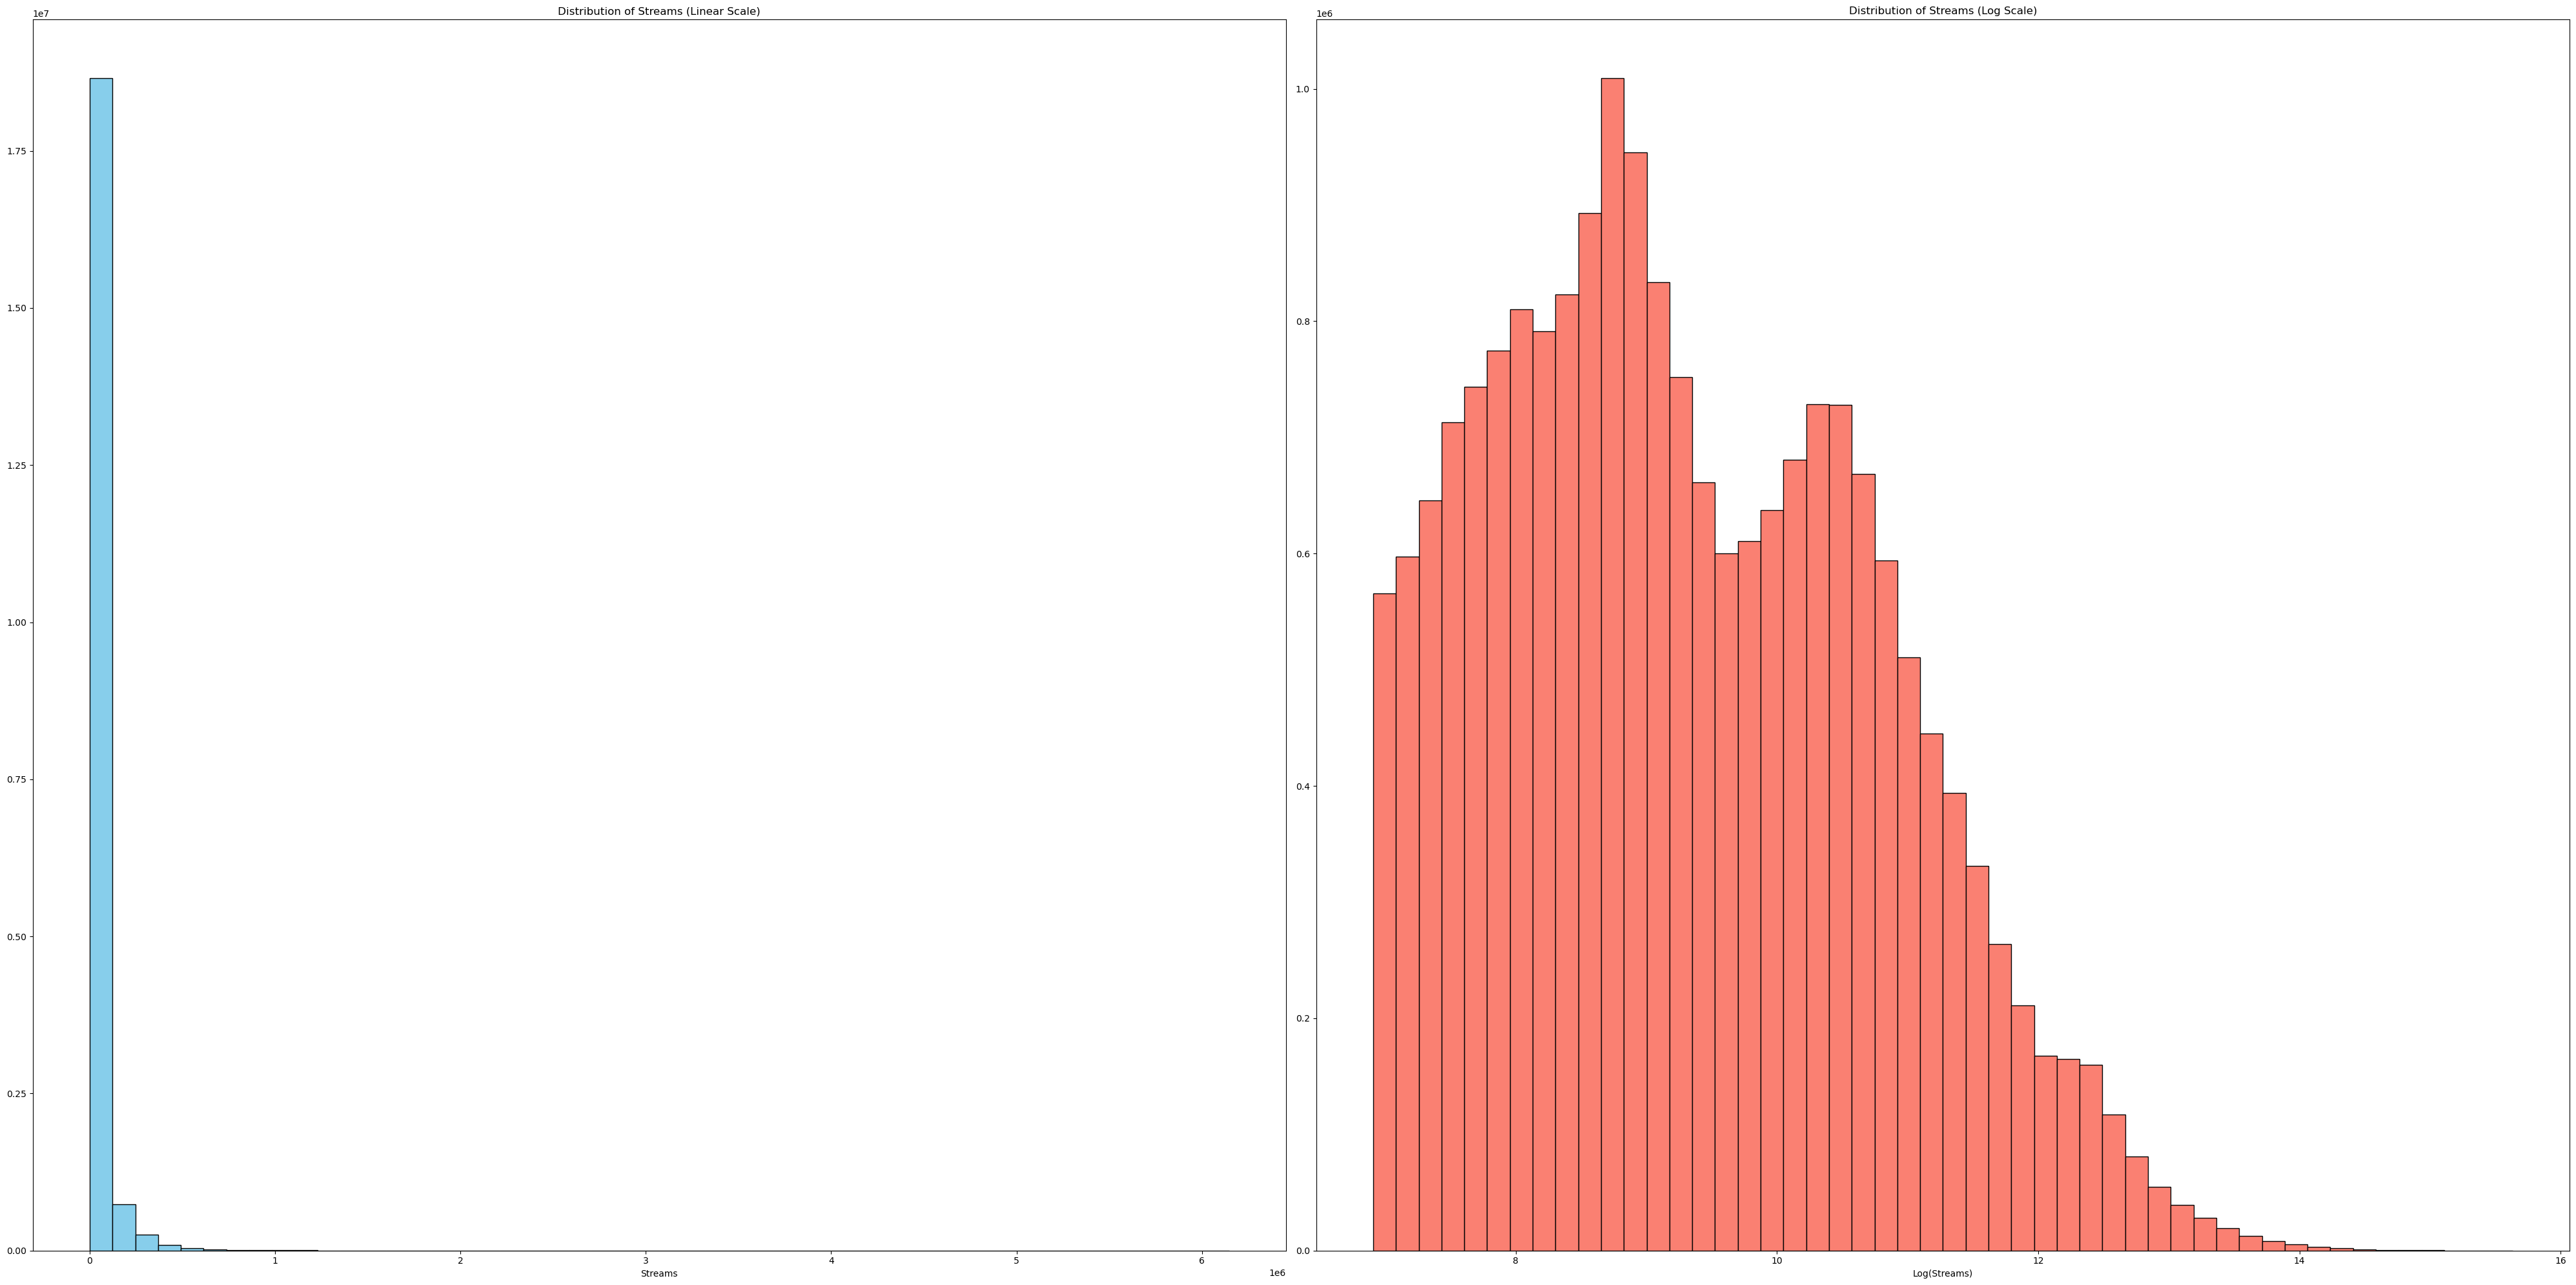

In [ ]:
# Sample the data for visualization (as the dataset is too big for full pandas plotting)
sample_df = con.execute("SELECT TRY_CAST(streams AS DOUBLE) as streams FROM spotify_full WHERE streams IS NOT NULL AND LOWER (region) != 'global' USING SAMPLE 26000000").df()

plt.figure(figsize=(40, 20))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution 
plt.subplot(1, 2, 2)
plt.hist(np.log1p(sample_df['streams']), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()

These are all daily streams mapped accross countries. The distribution is heavily skewed because some songs are played 6 million times e.g. Drake in the US while most entries are from smaller countries where streams are significantly lower e.g., Andorra. See the distribution below. 

── Stream value percentiles (full dataset) ──────────────────


,p50,p90,p95,p99,p999,max_streams
0,9201.0,81240.0,141359.0,355946.44,909675.222,6146233.0



── Top 20 highest-stream entries ────────────────────────────


,date,title,artist,region,chart,rank,streams,year
0,2021-09-03,Girls Want Girls (with Lil Baby),Drake,United States,top200,1,6146233,2021
1,2021-01-12,drivers license,Olivia Rodrigo,United States,top200,1,6145601,2021
2,2021-09-03,Champagne Poetry,Drake,United States,top200,2,5953619,2021
3,2018-06-29,Nonstop,Drake,United States,top200,1,5749019,2018
4,2021-01-13,drivers license,Olivia Rodrigo,United States,top200,1,5723851,2021
5,2021-01-11,drivers license,Olivia Rodrigo,United States,top200,1,5688246,2021
6,2021-09-03,Fair Trade (with Travis Scott),Drake,United States,top200,3,5616734,2021
7,2021-10-15,Easy On Me,Adele,United States,top200,1,5435431,2021
8,2021-01-14,drivers license,Olivia Rodrigo,United States,top200,1,5271136,2021
9,2018-06-29,Survival,Drake,United States,top200,2,5219711,2018



── Entries above stream thresholds ──────────────────────────
  streams >    6,000,000 :        2 entries
  streams >    3,000,000 :      275 entries
  streams >    1,000,000 :   15,037 entries
  streams >      500,000 :   94,398 entries

── Histogram of streams above the 99th percentile ──────────


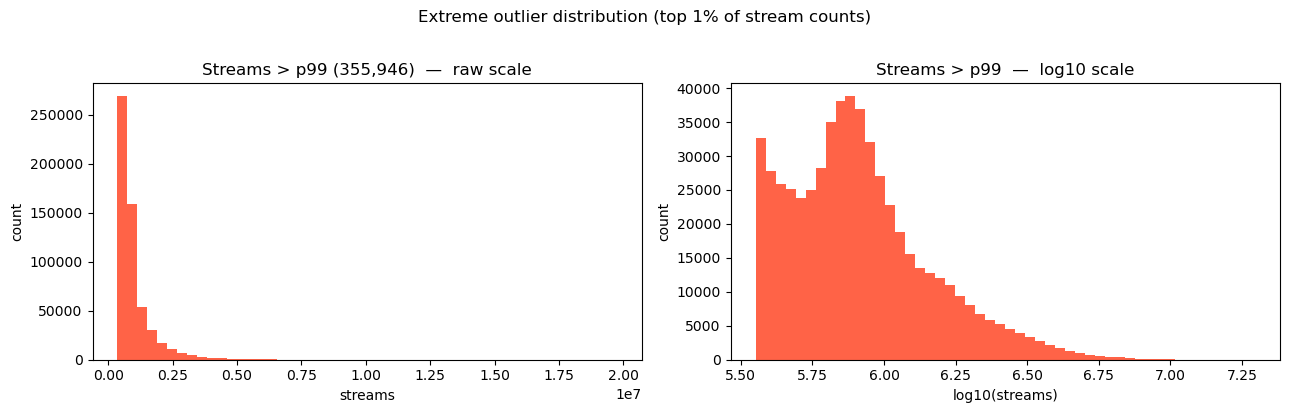


Note: The bulk of data sits around 9,201 streams (median).
The very top entries reach 6,146,233 streams — ~668× the median.


In [ ]:
# 1. Key percentiles to see where the tail starts
print("── Stream value percentiles (full dataset) ──────────────────")
pcts = con.execute("""
    SELECT
        PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p50,
        PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p90,
        PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p95,
        PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p99,
        PERCENTILE_CONT(0.999) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p999,
        MAX(TRY_CAST(streams AS DOUBLE)) AS max_streams
    FROM spotify_full
    WHERE streams IS NOT NULL AND LOWER(region) != 'global'
""").df()
display(pcts)

# 2. Top 20 individual entries by stream count
print("\n── Top 20 highest-stream entries ────────────────────────────")
top20 = con.execute("""
    SELECT
        date,
        title,
        artist,
        region,
        chart,
        TRY_CAST(rank    AS INTEGER) AS rank,
        TRY_CAST(streams AS BIGINT)  AS streams,
        year
    FROM spotify_full
    WHERE streams IS NOT NULL AND LOWER(region) != 'global'
    ORDER BY TRY_CAST(streams AS DOUBLE) DESC
    LIMIT 20
""").df()
display(top20)

# 3. How many entries exceed common "suspicious" thresholds?
print("\n── Entries above stream thresholds ──────────────────────────")
thresholds = [6_000_000, 3_000_000, 1_000_000, 500_000]
for t in thresholds:
    n = con.execute(f"""
        SELECT COUNT(*) FROM spotify_full
        WHERE TRY_CAST(streams AS DOUBLE) > {t} AND LOWER(region) != 'global'
    """).fetchone()[0]
    print(f"  streams > {t:>12,} : {n:>8,} entries")

# 4. Distribution of the top 1% visually
print("\n── Histogram of streams above the 99th percentile ──────────")
p99_val = float(pcts["p99"].iloc[0])
top1pct = con.execute(f"""
    SELECT TRY_CAST(streams AS DOUBLE) AS streams
    FROM spotify_full
    WHERE TRY_CAST(streams AS DOUBLE) > {p99_val}
      AND streams IS NOT NULL 
""").df()

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(top1pct["streams"], bins=50, color="tomato", edgecolor="none")
axes[0].set_title(f"Streams > p99 ({p99_val:,.0f})  —  raw scale")
axes[0].set_xlabel("streams")
axes[0].set_ylabel("count")

axes[1].hist(np.log10(top1pct["streams"]), bins=50, color="tomato", edgecolor="none")
axes[1].set_title("Streams > p99  —  log10 scale")
axes[1].set_xlabel("log10(streams)")
axes[1].set_ylabel("count")

plt.suptitle("Extreme outlier distribution (top 1% of stream counts)", y=1.02)
plt.tight_layout()
plt.show()

print(f"\nNote: The bulk of data sits around {float(pcts['p50'].iloc[0]):,.0f} streams (median).")
print(f"The very top entries reach {int(pcts['max_streams'].iloc[0]):,} streams — "
      f"~{int(pcts['max_streams'].iloc[0]) / float(pcts['p50'].iloc[0]):.0f}× the median.")

## 8. Analysis and Findings

### 8.1 Country Analysis

════════════════════════════════════════════════════════════
  AVERAGE STREAMS PER COUNTRY
════════════════════════════════════════════════════════════

  Total countries: 68


,region,n_entries,avg_streams,median_streams,max_streams,total_streams
0,United States,364081,390255.989208,294790.0,6146233,1.420848e+11
1,Brazil,364503,153263.777791,111785.0,2001683,5.586511e+10
2,Mexico,358331,127242.997592,97308.0,3680758,4.559511e+10
3,Germany,357342,111799.026311,80791.5,2629922,3.995049e+10
4,United Kingdom,359715,101198.344323,70095.0,2801638,3.640256e+10
...,...,...,...,...,...,...
63,Lithuania,152993,1938.003046,1520.0,86013,2.965009e+08
64,Estonia,107995,1790.969452,1486.0,29525,1.934157e+08
65,Latvia,150974,1728.479407,1448.0,23558,2.609554e+08
66,Bulgaria,94834,1707.914661,1401.0,30203,1.619684e+08


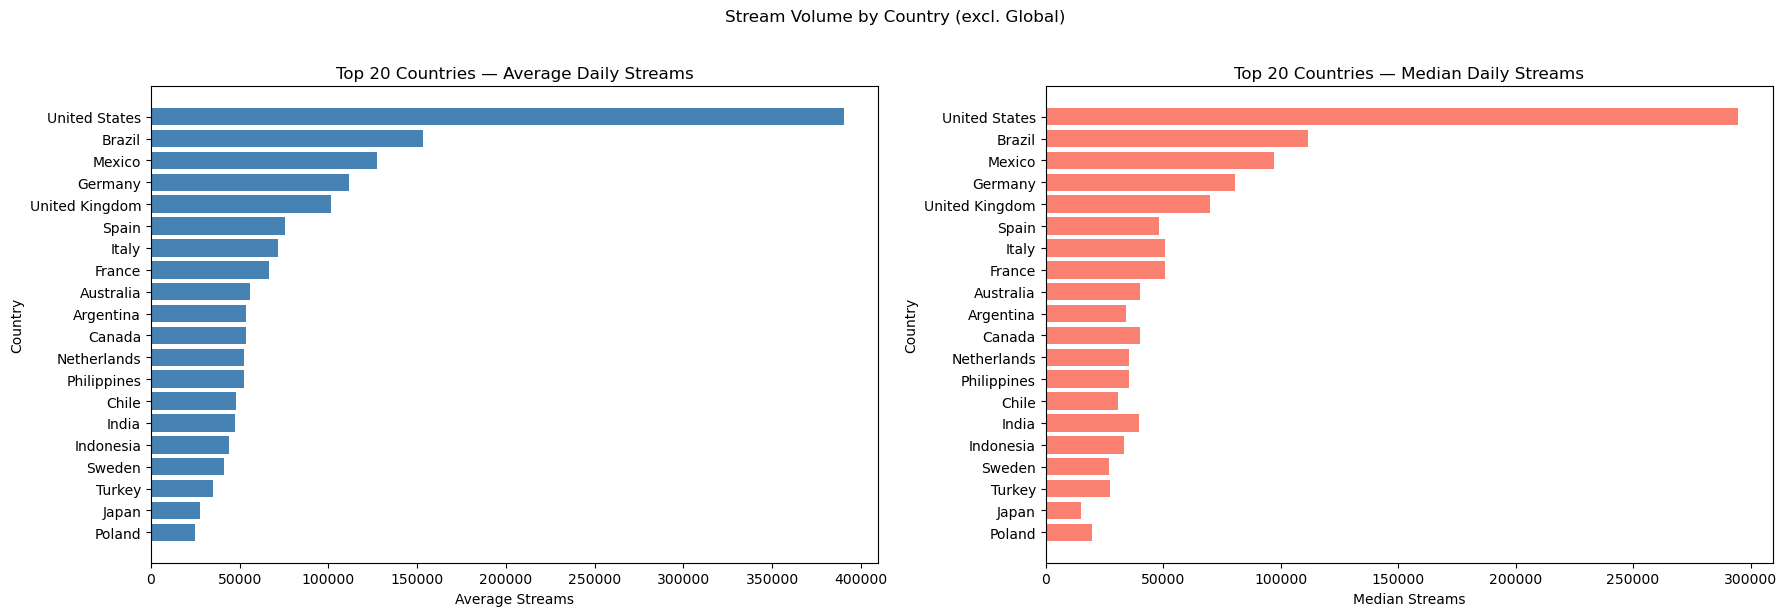


── Bottom 10 countries by average streams ───────────────────


,region,n_entries,avg_streams,median_streams,max_streams,total_streams
58,Egypt,123764,2551.200398,1936.0,74586,315746766.0
59,Slovakia,267583,2421.919012,1893.0,39470,648064355.0
60,United Arab Emirates,142051,2147.140823,1649.0,27573,305003501.0
61,Iceland,212061,2100.610112,1545.0,44069,445457481.0
62,Nicaragua,109995,2065.814528,1565.0,34289,227229269.0
63,Lithuania,152993,1938.003046,1520.0,86013,296500900.0
64,Estonia,107995,1790.969452,1486.0,29525,193415746.0
65,Latvia,150974,1728.479407,1448.0,23558,260955450.0
66,Bulgaria,94834,1707.914661,1401.0,30203,161968379.0
67,Luxembourg,8957,1658.866362,1386.0,16701,14858466.0


In [35]:
# Average streams per country (excluding global) 
print("═" * 60)
print("  AVERAGE STREAMS PER COUNTRY")
print("═" * 60)

avg_streams_country = con.execute("""
    SELECT
        region,
        COUNT(*)                                          AS n_entries,
        AVG(TRY_CAST(streams AS DOUBLE))                 AS avg_streams,
        MEDIAN(TRY_CAST(streams AS DOUBLE))              AS median_streams,
        MAX(TRY_CAST(streams AS BIGINT))                 AS max_streams,
        SUM(TRY_CAST(streams AS BIGINT))                 AS total_streams
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY region
    ORDER BY avg_streams DESC
""").df()

print(f"\n  Total countries: {len(avg_streams_country):,}")
display(avg_streams_country)

# Bar chart: Top 20 countries by average streams 
top20 = avg_streams_country.head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Average streams
axes[0].barh(top20["region"][::-1], top20["avg_streams"][::-1], color="steelblue")
axes[0].set_title("Top 20 Countries — Average Daily Streams")
axes[0].set_xlabel("Average Streams")
axes[0].set_ylabel("Country")

# Median streams (less affected by outliers)
axes[1].barh(top20["region"][::-1], top20["median_streams"][::-1], color="salmon")
axes[1].set_title("Top 20 Countries — Median Daily Streams")
axes[1].set_xlabel("Median Streams")
axes[1].set_ylabel("Country")

plt.suptitle("Stream Volume by Country (excl. Global)", y=1.02)
plt.tight_layout()
plt.show()

# Bottom 10 countries by average streams 
print("\n── Bottom 10 countries by average streams ───────────────────")
display(avg_streams_country.tail(10))

In [36]:
# ── Shortest & Longest chart stay for a single song in any one country ────────
# span_days = (last chart date − first chart date) + 1  for a given track × country
# "Shortest" = songs that appeared only 1 day in a country (span_days = 1)
# We show the top 10 on each end, plus the single extreme examples.

extremes = con.execute("""
    WITH song_spans AS (
        SELECT
            track_id,
            MAX(title)                                                           AS title,
            MAX(artist)                                                          AS artist,
            region,
            MIN(TRY_CAST(date AS DATE))                                          AS first_date,
            MAX(TRY_CAST(date AS DATE))                                          AS last_date,
            DATEDIFF('day',
                     MIN(TRY_CAST(date AS DATE)),
                     MAX(TRY_CAST(date AS DATE))) + 1                            AS span_days,
            COUNT(*)                                                             AS chart_entries,
            ROUND(AVG(TRY_CAST(rank AS DOUBLE)), 1)                              AS avg_rank
        FROM spotify_full
        WHERE region IS NOT NULL
          AND LOWER(region) != 'global'
          AND track_id IS NOT NULL
          AND title IS NOT NULL
          AND streams IS NOT NULL
        GROUP BY track_id, region
    )
    SELECT * FROM song_spans
    ORDER BY span_days DESC, chart_entries DESC
""").df()

# ── LONGEST stay ──────────────────────────────────────────────────────────────
print("═" * 70)
print("  TOP 10 LONGEST CHART STAYS — single song in a single country")
print("═" * 70)
longest = extremes.head(10)[["title", "artist", "region", "first_date",
                               "last_date", "span_days", "chart_entries", "avg_rank"]]
display(longest.reset_index(drop=True))

# ── SHORTEST stay (span_days = 1, i.e. appeared on exactly one date) ──────────
print("\n" + "═" * 70)
print("  SONGS WITH THE SHORTEST CHART STAY (appeared on only 1 day in a country)")
print("═" * 70)

one_day = extremes[extremes["span_days"] == 1].copy()
print(f"\n  Total (track × country) combos with a 1-day stay : {len(one_day):,}")
print(f"  Distinct tracks                                   : {one_day['track_id'].nunique():,}")
print(f"  Distinct countries                                : {one_day['region'].nunique():,}")
print("\n  Sample of 10 one-day chart appearances:")
display(
    one_day[["title", "artist", "region", "first_date", "chart_entries", "avg_rank"]]
    .head(10)
    .reset_index(drop=True)
)

# ── Summary banner ────────────────────────────────────────────────────────────
longest_row  = extremes.iloc[0]
shortest_row = one_day.sort_values("chart_entries").iloc[0]

print("\n" + "═" * 70)
print("  SUMMARY")
print("═" * 70)
print(f"\n  Longest single-country chart run:")
print(f"     Song    : {longest_row['title']}")
print(f"     Artist  : {longest_row['artist']}")
print(f"     Country : {longest_row['region']}")
print(f"     Period  : {longest_row['first_date']}  →  {longest_row['last_date']}")
print(f"     Span    : {int(longest_row['span_days'])} days  ({int(longest_row['chart_entries'])} chart entries)")

print(f"\n  ⚡ Shortest single-country chart run (1 day):")
print(f"     Song    : {shortest_row['title']}")
print(f"     Artist  : {shortest_row['artist']}")
print(f"     Country : {shortest_row['region']}")
print(f"     Date    : {shortest_row['first_date']}")
print(f"     Entries : {int(shortest_row['chart_entries'])}  (avg rank {shortest_row['avg_rank']})")


══════════════════════════════════════════════════════════════════════
  TOP 10 LONGEST CHART STAYS — single song in a single country
══════════════════════════════════════════════════════════════════════


,title,artist,region,first_date,last_date,span_days,chart_entries,avg_rank
0,Ohne mein Team,"Bonez MC, RAF Camora, Maxwell",Austria,2017-01-01,2021-12-31,1826,1806,96.4
1,goosebumps,Travis Scott,United States,2017-01-01,2021-12-31,1826,1778,97.1
2,No Role Modelz,J. Cole,United States,2017-01-01,2021-12-31,1826,1474,128.7
3,Don't Stop Believin',Journey,Austria,2017-01-01,2021-12-31,1826,878,173.0
4,Without Me,Eminem,Austria,2017-01-01,2021-12-31,1826,532,166.1
5,Ocho Cuarenta,Rodrigo,Argentina,2017-01-01,2021-12-31,1826,503,150.1
6,Una Cerveza,Rafaga,Argentina,2017-01-01,2021-12-31,1826,484,150.0
7,Deja De Llorar,El Polaco,Argentina,2017-01-01,2021-12-31,1826,294,147.9
8,Die For You,The Weeknd,United States,2017-01-01,2021-12-31,1826,282,155.7
9,Noche Loca,"Marama, Rombai",Argentina,2017-01-01,2021-12-31,1826,271,137.8



══════════════════════════════════════════════════════════════════════
  SONGS WITH THE SHORTEST CHART STAY (appeared on only 1 day in a country)
══════════════════════════════════════════════════════════════════════

  Total (track × country) combos with a 1-day stay : 76,989
  Distinct tracks                                   : 39,010
  Distinct countries                                : 68

  Sample of 10 one-day chart appearances:


,title,artist,region,first_date,chart_entries,avg_rank
0,Wicked Game,Chris Isaak,Sweden,2017-09-20,2,168.0
1,Love Not Lovers,The Script,Taiwan,2017-09-01,2,199.0
2,BABE,HyunA,Taiwan,2017-09-26,2,184.0
3,No Man is an Island,The Script,Netherlands,2017-09-01,2,171.0
4,Deborah,Casper,Austria,2017-09-01,2,163.0
5,No Man is an Island,The Script,Ireland,2017-09-01,2,168.0
6,ใครอีกคน,BOWKYLION,Thailand,2017-09-06,2,139.0
7,No Man is an Island,The Script,Malaysia,2017-09-01,2,155.0
8,Love Not Lovers,The Script,Netherlands,2017-09-01,2,150.0
9,Love Not Lovers,The Script,Singapore,2017-09-01,2,183.0



══════════════════════════════════════════════════════════════════════
  SUMMARY
══════════════════════════════════════════════════════════════════════

  Longest single-country chart run:
     Song    : Ohne mein Team
     Artist  : Bonez MC, RAF Camora, Maxwell
     Country : Austria
     Period  : 2017-01-01 00:00:00  →  2021-12-31 00:00:00
     Span    : 1826 days  (1806 chart entries)

  ⚡ Shortest single-country chart run (1 day):
     Song    : RAW SHIT (feat. Migos)
     Artist  : DaBaby
     Country : Romania
     Date    : 2019-09-27 00:00:00
     Entries : 1  (avg rank 154.0)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

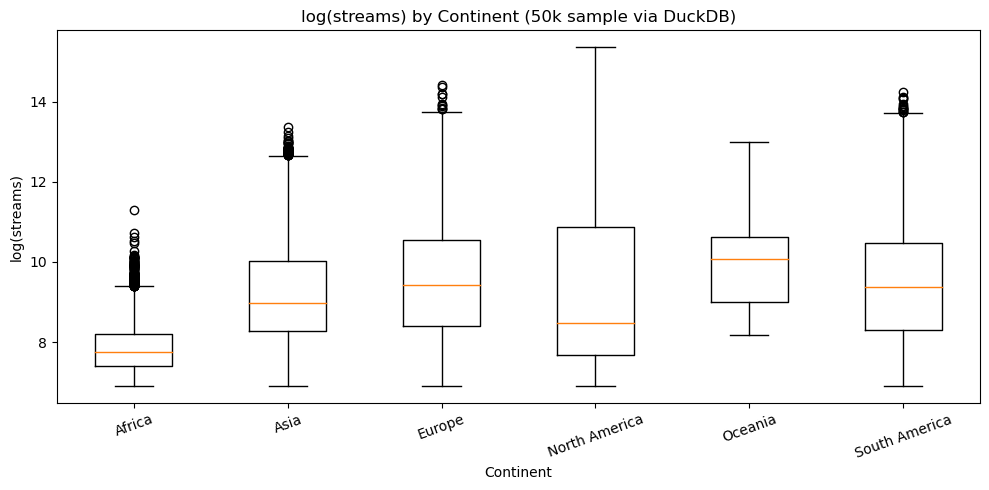

In [37]:
continent_df = con.execute("""
    SELECT
        LN(TRY_CAST(streams AS DOUBLE)) AS log_streams,
        country_continent
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND TRY_CAST(streams AS DOUBLE) > 0
      AND LOWER(region) != 'global'
      AND country_continent IS NOT NULL
    USING SAMPLE 500000
""").df()

continents = sorted(continent_df["country_continent"].dropna().unique())
groups = [
    continent_df.loc[continent_df["country_continent"] == c, "log_streams"].dropna().values
    for c in continents
]

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(groups, labels=continents, vert=True)
ax.set_title("log(streams) by Continent (50k sample via DuckDB)")
ax.set_xlabel("Continent")
ax.set_ylabel("log(streams)")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()


The country analysis reveals strong heterogeneity in average and median daily streams across markets. The United States dominates by a large margin, followed by Brazil, Mexico, Germany, and the United Kingdom. These markets show substantially higher stream volumes compared to smaller European countries such as Luxembourg, Bulgaria, or Latvia.

The gap between mean and median streams suggests that larger markets are more influenced by viral outliers, whereas smaller markets exhibit more stable but lower stream distributions. The observed differences in stream volume are consistent with variations in population size and overall platform penetration, indicating that structural market characteristics play an important role.

Overall, these findings indicate that international rollout decisions cannot treat countries uniformly. Market-specific dynamics significantly influence stream performance, reinforcing the importance of a data-driven system that ranks target markets based on expected impact and timing.

### 8.2 Artist Analysis

═════════════════════════════════════════════════════════════════
  1) BIGGEST ARTISTS IN THE DATA
═════════════════════════════════════════════════════════════════

  Total unique artists: 39,890

── Top 20 artists by chart appearances ──────────────────────


,artist,chart_appearances,unique_songs,countries_reached,active_days,avg_rank,total_streams
0,Ed Sheeran,355703,123,68,1823,95.7,1.051741e+10
1,Billie Eilish,222671,67,68,1404,93.7,7.527774e+09
2,Post Malone,189243,71,68,1823,88.7,9.338347e+09
3,Bad Bunny,184950,62,65,1823,84.0,5.150676e+09
4,Dua Lipa,169748,47,68,1823,82.9,5.605296e+09
5,Ariana Grande,169097,90,68,1823,85.9,7.015974e+09
6,Drake,150884,153,68,1822,83.4,8.866556e+09
7,Imagine Dragons,139994,89,68,1823,102.6,3.223163e+09
8,XXXTENTACION,135503,62,66,1797,108.9,5.499213e+09
9,The Weeknd,130631,59,68,1705,71.4,5.750073e+09



── Top 20 artists by unique songs ───────────────────────────


,artist,chart_appearances,unique_songs,countries_reached,active_days,avg_rank,total_streams
394,Jul,8003,257,5,1589,109.6,4.728192e+08
10,BTS,130056,230,68,1823,94.2,3.381890e+09
20,Taylor Swift,83198,214,68,1667,100.3,3.928982e+09
93,TWICE,27775,171,33,1810,105.7,5.045369e+08
6,Drake,150884,153,68,1822,83.4,8.866556e+09
8688,Die drei ???,179,138,1,35,166.0,9.696489e+06
0,Ed Sheeran,355703,123,68,1823,95.7,1.051741e+10
13,Juice WRLD,106780,123,68,1351,100.9,6.363268e+09
722,Djadja & Dinaz,4710,121,4,1468,113.4,2.466783e+08
733,Tory Lanez,4650,116,42,1070,126.3,2.896469e+08


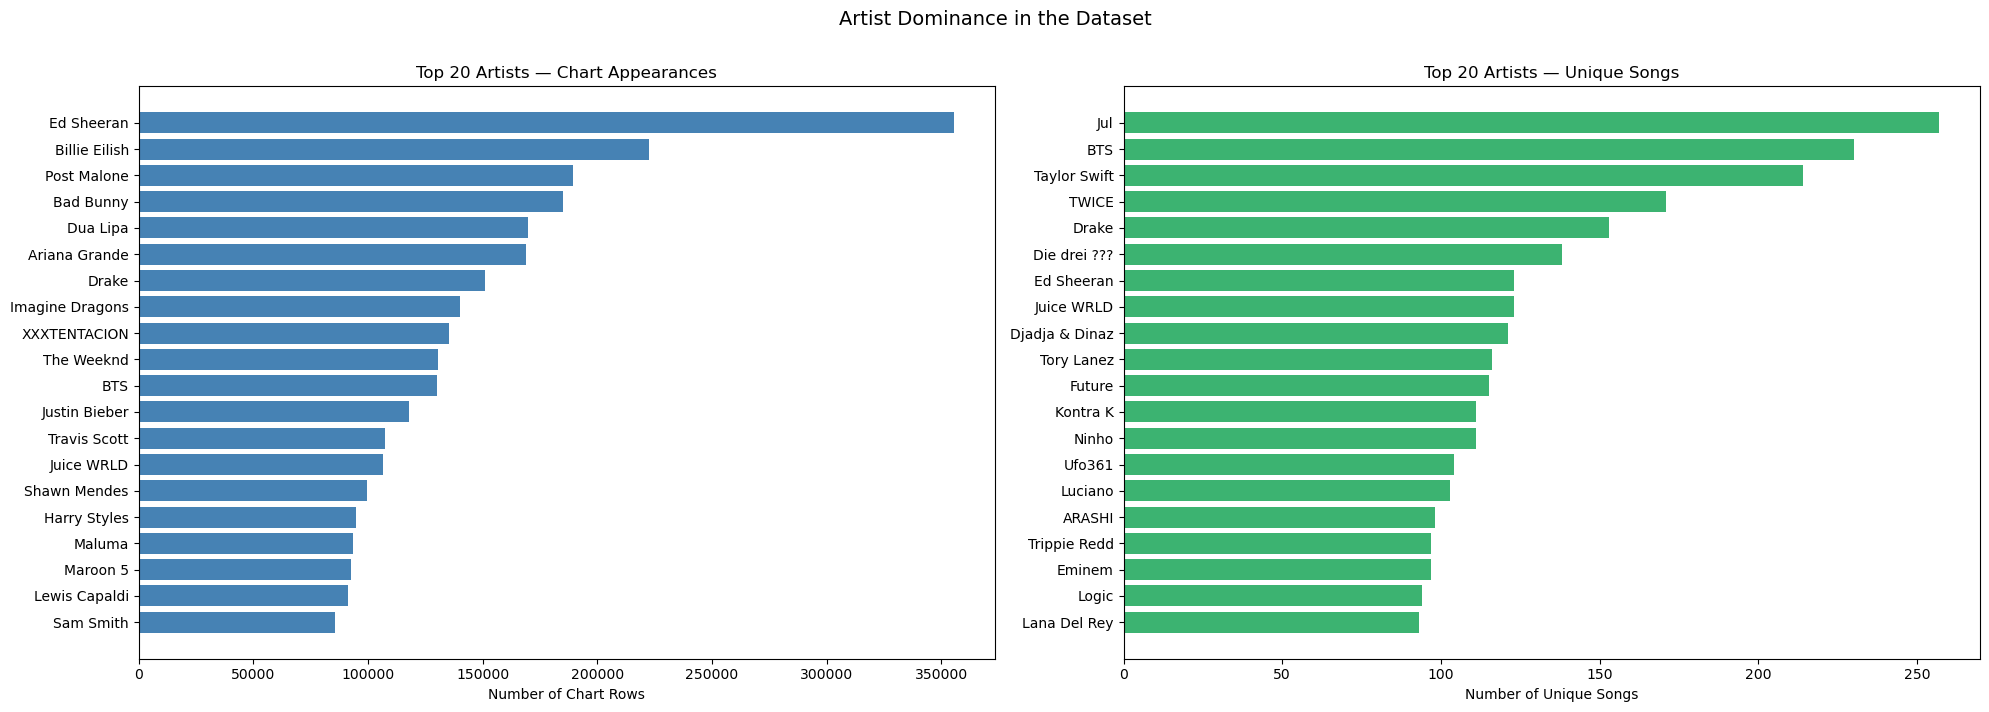

In [38]:
# 1. TOP ARTISTS BY CHART APPEARANCES & UNIQUE SONGS
print("═" * 65)
print("  1) BIGGEST ARTISTS IN THE DATA")
print("═" * 65)

top_artists_appearances = con.execute("""
    SELECT
        artist,
        COUNT(*)                        AS chart_appearances,
        COUNT(DISTINCT track_id)        AS unique_songs,
        COUNT(DISTINCT region)          AS countries_reached,
        COUNT(DISTINCT date)            AS active_days,
        ROUND(AVG(TRY_CAST(rank AS DOUBLE)), 1)    AS avg_rank,
        SUM(TRY_CAST(streams AS BIGINT))            AS total_streams
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND artist IS NOT NULL
      AND track_id IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY artist
    ORDER BY chart_appearances DESC
""").df()

print(f"\n  Total unique artists: {len(top_artists_appearances):,}")
print("\n── Top 20 artists by chart appearances ──────────────────────")
display(top_artists_appearances.head(20))

print("\n── Top 20 artists by unique songs ───────────────────────────")
display(top_artists_appearances.sort_values("unique_songs", ascending=False).head(20))

# Plot: Top 20 by appearances vs unique songs
top20_app  = top_artists_appearances.head(20)
top20_songs = top_artists_appearances.sort_values("unique_songs", ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].barh(top20_app["artist"][::-1], top20_app["chart_appearances"][::-1], color="steelblue")
axes[0].set_title("Top 20 Artists — Chart Appearances")
axes[0].set_xlabel("Number of Chart Rows")

axes[1].barh(top20_songs["artist"][::-1], top20_songs["unique_songs"][::-1], color="mediumseagreen")
axes[1].set_title("Top 20 Artists — Unique Songs")
axes[1].set_xlabel("Number of Unique Songs")

plt.suptitle("Artist Dominance in the Dataset", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

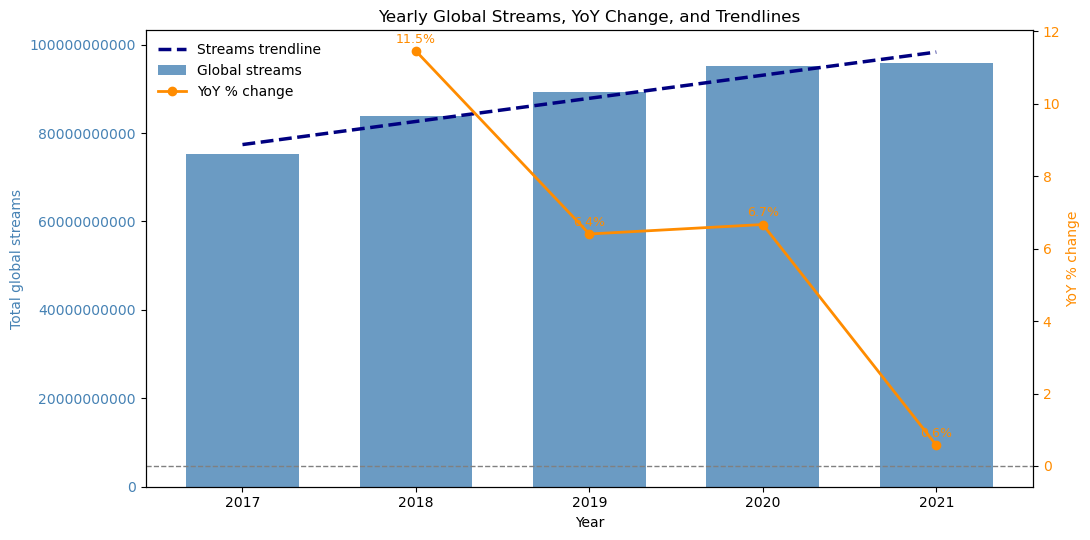

,year,global_streams,yoy_pct_change
0,2017,7.524887e+10,NaN
1,2018,8.387107e+10,11.458244
2,2019,8.924453e+10,6.406817
3,2020,9.519593e+10,6.668643
4,2021,9.574390e+10,0.575624


In [39]:
# Yearly global streams + YoY % difference with trendlines
yearly_global_streams_df = con.execute("""
WITH base AS (
    SELECT
        COALESCE(
            TRY_CAST(year AS INTEGER),
            EXTRACT(YEAR FROM TRY_CAST(date AS DATE))::INTEGER
        ) AS year_val,
        TRY_CAST(streams AS DOUBLE) AS streams_num
    FROM spotify_full
    WHERE LOWER(region) = 'global'
)
SELECT
    year_val AS year,
    SUM(streams_num) AS global_streams
FROM base
WHERE year_val IS NOT NULL
  AND streams_num IS NOT NULL
GROUP BY year_val
ORDER BY year_val;
""").df()

yearly_global_streams_df["yoy_pct_change"] = yearly_global_streams_df["global_streams"].pct_change() * 100

x_year = yearly_global_streams_df["year"].astype(int).values
y_streams = yearly_global_streams_df["global_streams"].values
y_yoy = yearly_global_streams_df["yoy_pct_change"].values

fig, ax1 = plt.subplots(figsize=(11, 5.5))

# Bars: yearly global streams
ax1.bar(x_year, y_streams, color="steelblue", alpha=0.8, width=0.65, label="Global streams")

# Trendline for global streams (linear)
coef_streams = np.polyfit(x_year, y_streams, 1)
trend_streams = np.polyval(coef_streams, x_year)
ax1.plot(x_year, trend_streams, color="navy", linewidth=2.5, linestyle="--", label="Streams trendline")

ax1.set_xlabel("Year")
ax1.set_ylabel("Total global streams", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xticks(x_year)

# Line: YoY percentage change
ax2 = ax1.twinx()
ax2.plot(x_year, y_yoy, color="darkorange", marker="o", linewidth=2, label="YoY % change")


ax2.set_ylabel("YoY % change", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")
ax2.axhline(0, color="gray", linestyle="--", linewidth=1)

for x, y in zip(x_year, y_yoy):
    if pd.notnull(y):
        ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 6), ha="center", color="darkorange", fontsize=9)

# Combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", frameon=False)

plt.title("Yearly Global Streams, YoY Change, and Trendlines")
fig.tight_layout()
plt.show()

display(yearly_global_streams_df)

The artist analysis shows strong concentration in chart dominance: although nearly 40,000 artists appear in the dataset, a small group of globally established artists accounts for a disproportionately large share of chart appearances and country reach. Top artists consistently chart across many countries and maintain long chart presence, while others show more localized or short-lived performance. There is substantial variability in the number of countries reached and the number of unique songs charting per artist. These differences highlight the importance of incorporating artist-level characteristics, such as prior chart history and international reach, when predicting cross-border breakout potential and rollout timing.

### 8.3 Country Spread Analysis

════════════════════════════════════════════════════════════
  SPREAD WIDTH PROPORTIONS
════════════════════════════════════════════════════════════

  Total songs analysed: 118,071

  Reach Tier                Songs        %   Cumulative %
  -------------------- ---------- -------- --------------
  1 country                86,347   73.13%         73.13%
  2–3 countries            17,810   15.08%         88.21%
  4–5 countries             3,809    3.23%         91.44%
  6–10 countries            3,354    2.84%         94.28%
  11–20 countries           3,158    2.67%         96.95%
  21–30 countries           1,217    1.03%         97.98%
  31–50 countries           1,496    1.27%         99.25%
  >50 countries               880    0.75%        100.00%


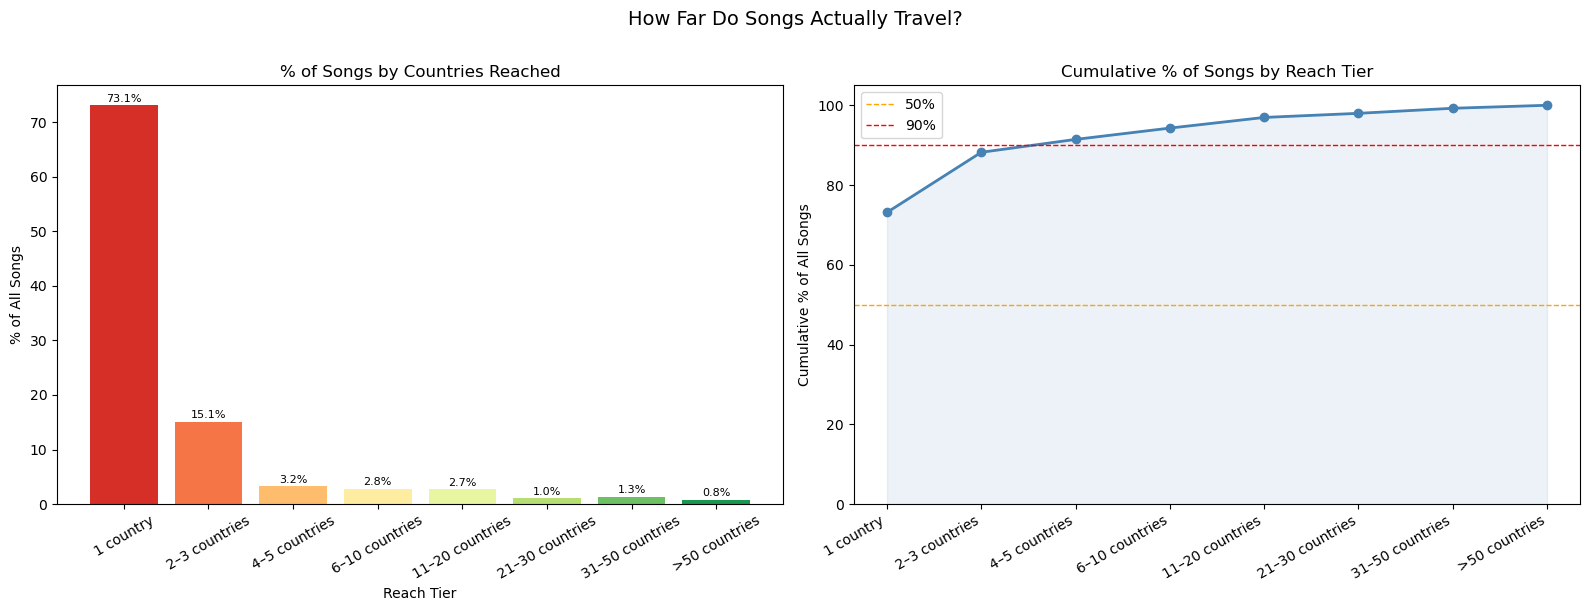


  Key takeaways:
  → 86,347 songs (73.1%) never left their first country
  → 2,376 songs (2.0%) reached more than 30 countries
  → Median reach: 1 countries
  → Mean reach  : 3.0 countries


In [42]:
# ── Compute spread (countries reached per song) via DuckDB ───────────────────
spread = con.execute("""
    WITH first_entry AS (
        SELECT
            track_id,
            artist,
            region,
            MIN(TRY_CAST(date AS DATE)) AS first_chart_date
        FROM spotify_full
        WHERE track_id  IS NOT NULL
          AND streams   IS NOT NULL
          AND region    IS NOT NULL
          AND LOWER(region) != 'global'
        GROUP BY track_id, artist, region
    ),
    global_debut AS (
        SELECT track_id, MIN(first_chart_date) AS global_debut
        FROM first_entry
        GROUP BY track_id
    ),
    travel AS (
        SELECT
            fe.track_id,
            fe.artist,
            fe.region,
            DATEDIFF('day', gd.global_debut, fe.first_chart_date) AS days_to_arrive
        FROM first_entry fe
        JOIN global_debut gd USING (track_id)
    ),
    origin AS (
        SELECT track_id, ANY_VALUE(region) AS origin_country
        FROM travel
        WHERE days_to_arrive = 0
        GROUP BY track_id
    )
    SELECT
        t.track_id,
        t.artist,
        o.origin_country,
        COUNT(DISTINCT t.region)                          AS countries_reached,
        MEDIAN(t.days_to_arrive)                          AS days_to_50pct,
        MAX(t.days_to_arrive)                             AS max_spread_days
    FROM travel t
    LEFT JOIN origin o USING (track_id)
    GROUP BY t.track_id, t.artist, o.origin_country
""").df()

# ── Spread Width Proportions — what % of songs reach how many countries ───────
print("═" * 60)
print("  SPREAD WIDTH PROPORTIONS")
print("═" * 60)

total_songs = len(spread)

# Define meaningful reach tiers
bins = [0, 1, 3, 5, 10, 20, 30, 50, float("inf")]
labels = ["1 country", "2–3 countries", "4–5 countries",
          "6–10 countries", "11–20 countries", "21–30 countries",
          "31–50 countries", ">50 countries"]

spread["reach_tier"] = pd.cut(
    spread["countries_reached"],
    bins=bins,
    labels=labels,
    right=True
)

tier_counts = (
    spread.groupby("reach_tier", observed=True)
    .size()
    .reset_index(name="n_songs")
)
tier_counts["pct"] = (tier_counts["n_songs"] / total_songs * 100).round(2)
tier_counts["cumulative_pct"] = tier_counts["pct"].cumsum().round(2)

print(f"\n  Total songs analysed: {total_songs:,}\n")
print(f"  {'Reach Tier':<20} {'Songs':>10} {'%':>8} {'Cumulative %':>14}")
print(f"  {'-'*20} {'-'*10} {'-'*8} {'-'*14}")
for _, row in tier_counts.iterrows():
    print(f"  {str(row['reach_tier']):<20} {int(row['n_songs']):>10,} {row['pct']:>7.2f}% {row['cumulative_pct']:>13.2f}%")

# ── Visualise ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.RdYlGn(np.linspace(0.1, 0.9, len(tier_counts)))

# Bar chart with % labels
bars = axes[0].bar(tier_counts["reach_tier"], tier_counts["pct"], color=colors, edgecolor="none")
axes[0].set_title("% of Songs by Countries Reached")
axes[0].set_xlabel("Reach Tier")
axes[0].set_ylabel("% of All Songs")
axes[0].tick_params(axis="x", rotation=30)
for bar, pct in zip(bars, tier_counts["pct"]):
    axes[0].text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 0.3,
                 f"{pct:.1f}%", ha="center", va="bottom", fontsize=8)

# Cumulative % line chart
axes[1].plot(tier_counts["reach_tier"], tier_counts["cumulative_pct"],
             marker="o", color="steelblue", linewidth=2)
axes[1].axhline(50,  color="orange", linestyle="--", linewidth=1, label="50%")
axes[1].axhline(90,  color="red",    linestyle="--", linewidth=1, label="90%")
axes[1].fill_between(range(len(tier_counts)), tier_counts["cumulative_pct"],
                     alpha=0.1, color="steelblue")
axes[1].set_xticks(range(len(tier_counts)))
axes[1].set_xticklabels(tier_counts["reach_tier"], rotation=30, ha="right")
axes[1].set_title("Cumulative % of Songs by Reach Tier")
axes[1].set_ylabel("Cumulative % of All Songs")
axes[1].set_ylim(0, 105)
axes[1].legend()

plt.suptitle("How Far Do Songs Actually Travel?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# ── Key takeaway numbers ──────────────────────────────────────────────────────
only_one   = int(tier_counts.loc[tier_counts["reach_tier"] == "1 country", "n_songs"].values[0])
over_thirty = spread[spread["countries_reached"] > 30].shape[0]
print(f"\n  Key takeaways:")
print(f"  → {only_one:,} songs ({only_one/total_songs*100:.1f}%) never left their first country")
print(f"  → {over_thirty:,} songs ({over_thirty/total_songs*100:.1f}%) reached more than 30 countries")
print(f"  → Median reach: {spread['countries_reached'].median():.0f} countries")
print(f"  → Mean reach  : {spread['countries_reached'].mean():.1f} countries")

Computing first chart date per track per country … (may take a moment)
  Rows (track × country × chart): 359,369
  Rows (track × country × chart): 359,369
  Songs tracked : 117,876
  Median days to arrive in a new country: 12 days
  Mean   days to arrive in a new country: 102.4 days
  Songs tracked : 117,876
  Median days to arrive in a new country: 12 days
  Mean   days to arrive in a new country: 102.4 days

════════════════════════════════════════════════════════════
  SPREAD WIDTH — songs by countries reached
════════════════════════════════════════════════════════════
  Median countries reached per song : 1
  Mean   countries reached per song : 3.0
  Songs reaching ≥ 30 countries     : 2,475
  Songs reaching ≥ 50 countries     : 943

════════════════════════════════════════════════════════════
  SPREAD WIDTH — songs by countries reached
════════════════════════════════════════════════════════════
  Median countries reached per song : 1
  Mean   countries reached per song : 3.0
  S

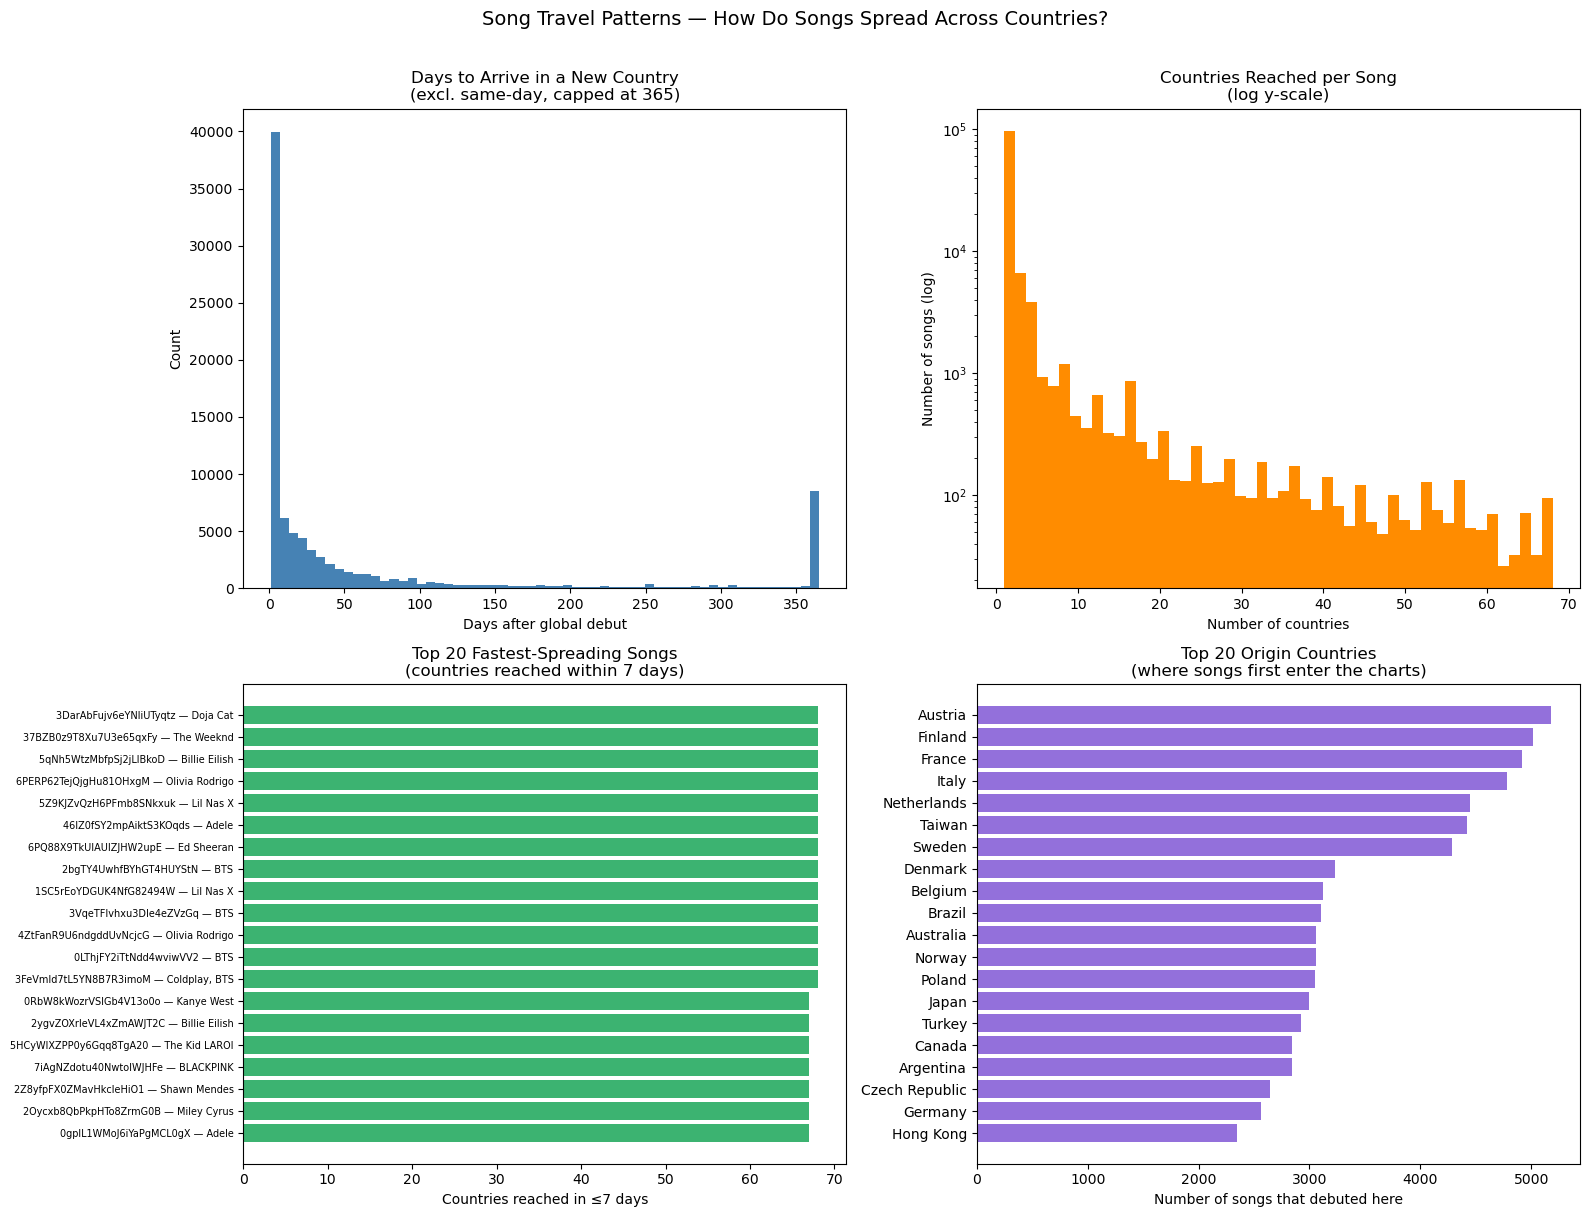


── Top 20 widest-spreading songs (most countries reached) ───


,artist,origin_country,countries_reached,days_to_50pct,max_spread_days
0,Lady Gaga,Argentina,68,0.0,250
1,BLACKPINK,Argentina,68,0.0,122
2,Doja Cat,United States,68,24.5,421
3,Ariana Grande,Argentina,68,0.0,94
4,BTS,Argentina,68,0.0,0
5,Dua Lipa,Argentina,68,0.0,311
6,Billie Eilish,Australia,68,0.0,81
7,Lil Nas X,Australia,68,0.0,42
8,Ariana Grande,Argentina,68,0.0,732
9,Doja Cat,Argentina,68,0.0,0



── Spread speed by chart type ───────────────────────────────


,chart,median_days,mean_days,n_arrivals
0,top200,12.0,102.4,90206


In [43]:
# For each (track_id, region) pair, find the first date it appeared on any chart.
# Then compute how many days after the track's global debut it reached each country.

# Step 1: First chart date per (track_id, region) 
print("Computing first chart date per track per country … (may take a moment)")

first_entry = con.execute("""
    SELECT
        track_id,
        artist,
        region,
        chart,
        MIN(CAST(date AS DATE)) AS first_chart_date
    FROM spotify_full
    WHERE track_id  IS NOT NULL
      AND streams   IS NOT NULL
      AND region    IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY track_id, artist, region, chart
""").df()

first_entry["first_chart_date"] = pd.to_datetime(first_entry["first_chart_date"])
print(f"  Rows (track × country × chart): {len(first_entry):,}")

# Step 2: Global debut = earliest first_chart_date across all countries 
global_debut = (
    first_entry
    .groupby("track_id")["first_chart_date"]
    .min()
    .reset_index()
    .rename(columns={"first_chart_date": "global_debut"})
)

travel = first_entry.merge(global_debut, on="track_id")
travel["days_to_arrive"] = (travel["first_chart_date"] - travel["global_debut"]).dt.days

# Origin country = the country where days_to_arrive == 0
origin = (
    travel[travel["days_to_arrive"] == 0]
    .groupby("track_id")["region"]
    .agg(lambda x: x.mode().iloc[0])   # most common origin when tied
    .reset_index()
    .rename(columns={"region": "origin_country"})
)
travel = travel.merge(origin, on="track_id", how="left")

print(f"  Songs tracked : {travel['track_id'].nunique():,}")
print(f"  Median days to arrive in a new country: {travel[travel['days_to_arrive'] > 0]['days_to_arrive'].median():.0f} days")
print(f"  Mean   days to arrive in a new country: {travel[travel['days_to_arrive'] > 0]['days_to_arrive'].mean():.1f} days")

# Step 3: Spread width per song 
spread = (
    travel.groupby(["track_id", "artist", "origin_country"])
    .agg(
        countries_reached = ("region",          "nunique"),
        days_to_50pct     = ("days_to_arrive",  lambda x: x.quantile(0.5)),
        max_spread_days   = ("days_to_arrive",  "max"),
    )
    .reset_index()
)

print("\n" + "═" * 60)
print("  SPREAD WIDTH — songs by countries reached")
print("═" * 60)
print(f"  Median countries reached per song : {spread['countries_reached'].median():.0f}")
print(f"  Mean   countries reached per song : {spread['countries_reached'].mean():.1f}")
print(f"  Songs reaching ≥ 30 countries     : {(spread['countries_reached'] >= 30).sum():,}")
print(f"  Songs reaching ≥ 50 countries     : {(spread['countries_reached'] >= 50).sum():,}")

# Step 4: Visualisations 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Distribution of days_to_arrive (excluding same-day)
later = travel[travel["days_to_arrive"] > 0]["days_to_arrive"].clip(upper=365)
axes[0, 0].hist(later, bins=60, color="steelblue", edgecolor="none")
axes[0, 0].set_title("Days to Arrive in a New Country\n(excl. same-day, capped at 365)")
axes[0, 0].set_xlabel("Days after global debut")
axes[0, 0].set_ylabel("Count")

# (b) Distribution of spread width (# countries per song)
axes[0, 1].hist(spread["countries_reached"], bins=50, color="darkorange", edgecolor="none")
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Countries Reached per Song\n(log y-scale)")
axes[0, 1].set_xlabel("Number of countries")
axes[0, 1].set_ylabel("Number of songs (log)")

# (c) Top 20 fastest-spreading songs (most countries within 7 days)
fast = (
    travel[travel["days_to_arrive"] <= 7]
    .groupby(["track_id", "artist"])["region"]
    .nunique()
    .reset_index()
    .rename(columns={"region": "countries_in_7d"})
    .sort_values("countries_in_7d", ascending=False)
    .head(20)
)
axes[1, 0].barh(
    (fast["track_id"].str[:25] + " — " + fast["artist"].str[:15])[::-1],
    fast["countries_in_7d"][::-1],
    color="mediumseagreen"
)
axes[1, 0].set_title("Top 20 Fastest-Spreading Songs\n(countries reached within 7 days)")
axes[1, 0].set_xlabel("Countries reached in ≤7 days")
axes[1, 0].tick_params(axis="y", labelsize=7)

# (d) Top 20 most common origin countries (where songs chart first)
top_origins = (
    origin.merge(spread[["track_id"]], on="track_id")
    .groupby("origin_country")
    .size()
    .reset_index(name="n_songs_originated")
    .sort_values("n_songs_originated", ascending=False)
    .head(20)
)
axes[1, 1].barh(
    top_origins["origin_country"][::-1],
    top_origins["n_songs_originated"][::-1],
    color="mediumpurple"
)
axes[1, 1].set_title("Top 20 Origin Countries\n(where songs first enter the charts)")
axes[1, 1].set_xlabel("Number of songs that debuted here")

plt.suptitle("Song Travel Patterns — How Do Songs Spread Across Countries?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Step 5: Top 20 widest-spreading songs 
print("\n── Top 20 widest-spreading songs (most countries reached) ───")
display(
    spread.sort_values("countries_reached", ascending=False)
    .head(20)[["artist", "origin_country",
               "countries_reached", "days_to_50pct", "max_spread_days"]]
    .reset_index(drop=True)
)

# Step 6: Spread speed by chart type 
print("\n── Spread speed by chart type ───────────────────────────────")
chart_speed = (
    travel[travel["days_to_arrive"] > 0]
    .groupby("chart")["days_to_arrive"]
    .agg(["median", "mean", "count"])
    .round(1)
    .rename(columns={"median": "median_days", "mean": "mean_days", "count": "n_arrivals"})
    .sort_values("median_days")
    .reset_index()
)
display(chart_speed)


════════════════════════════════════════════════════════════
  DIAGNOSING THE 365-DAY SPIKE
════════════════════════════════════════════════════════════

  Total arrivals with days_to_arrive > 0  : 90,206
  Arrivals with exactly 365 days          : 185
  Arrivals with days_to_arrive > 365      : 7,700
  Arrivals within ±5 days of 365          : 1,050

  ➜ The spike = 7,885 observations piled into one bin by .clip(upper=365)

── Arrivals by time bucket ──────────────────────────────────
  ≤ 7d           39,994  ( 44.3%)  ████████████████████████████████████████████
  8–30d          18,164  ( 20.1%)  ████████████████████
  31–90d         13,859  ( 15.4%)  ███████████████
  91–180d         5,203  (  5.8%)  █████
  181–365d        5,286  (  5.9%)  █████
  366–730d        4,167  (  4.6%)  ████
  > 730d          3,533  (  3.9%)  ███


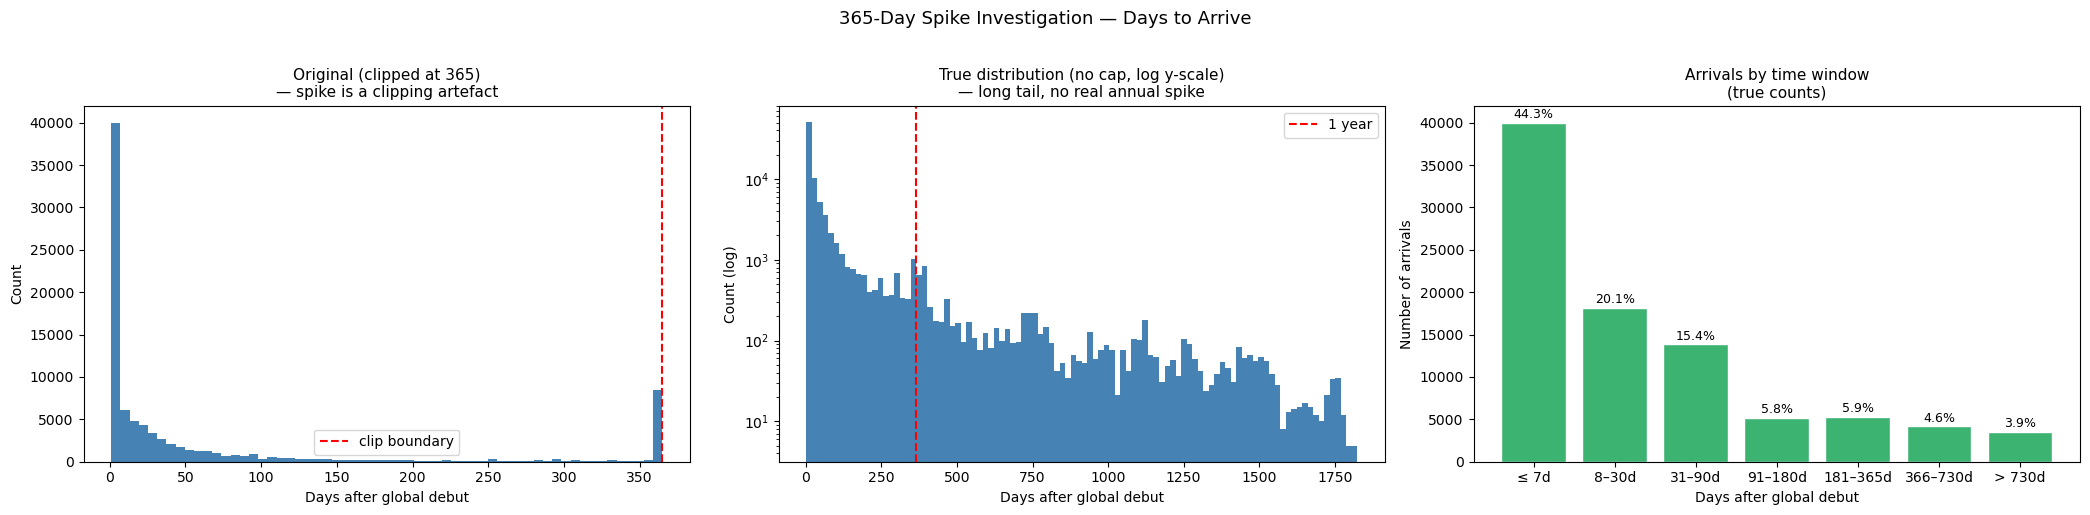

In [59]:
# ── Investigate the 365-day spike ────────────────────────────────────────────
later = travel[travel["days_to_arrive"] > 0]["days_to_arrive"]

# 1. Prove the spike is a clipping artefact
total_over_365  = (later > 365).sum()
total_at_365    = (later == 365).sum()
total_near_365  = ((later >= 360) & (later <= 370)).sum()

print("═" * 60)
print("  DIAGNOSING THE 365-DAY SPIKE")
print("═" * 60)
print(f"\n  Total arrivals with days_to_arrive > 0  : {len(later):,}")
print(f"  Arrivals with exactly 365 days          : {total_at_365:,}")
print(f"  Arrivals with days_to_arrive > 365      : {total_over_365:,}")
print(f"  Arrivals within ±5 days of 365          : {total_near_365:,}")
print(f"\n  ➜ The spike = {total_at_365 + total_over_365:,} observations piled into one bin by .clip(upper=365)")

# 2. Time-bucket breakdown of the real distribution
bins   = [0, 7, 30, 90, 180, 365, 730, float("inf")]
labels = ["≤ 7d", "8–30d", "31–90d", "91–180d", "181–365d", "366–730d", "> 730d"]
bucket = pd.cut(later, bins=bins, labels=labels, right=True)
bucket_counts = bucket.value_counts().reindex(labels)
bucket_pct    = (bucket_counts / len(later) * 100).round(1)

print("\n── Arrivals by time bucket ──────────────────────────────────")
for label, count, pct in zip(labels, bucket_counts, bucket_pct):
    bar = "█" * int(pct / 1)
    print(f"  {label:<12}  {count:>7,}  ({pct:>5.1f}%)  {bar}")

# 3. Side-by-side: original (clipped) vs corrected plots
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# (a) Original clipped histogram — reproduces the artefact
axes[0].hist(later.clip(upper=365), bins=60, color="steelblue", edgecolor="none")
axes[0].axvline(365, color="red", lw=1.5, ls="--", label="clip boundary")
axes[0].set_title("Original (clipped at 365)\n— spike is a clipping artefact", fontsize=11)
axes[0].set_xlabel("Days after global debut")
axes[0].set_ylabel("Count")
axes[0].legend()

# (b) True distribution, uncapped, log y-scale
axes[1].hist(later, bins=100, color="steelblue", edgecolor="none")
axes[1].set_yscale("log")
axes[1].axvline(365, color="red", lw=1.5, ls="--", label="1 year")
axes[1].set_title("True distribution (no cap, log y-scale)\n— long tail, no real annual spike", fontsize=11)
axes[1].set_xlabel("Days after global debut")
axes[1].set_ylabel("Count (log)")
axes[1].legend()

# (c) Bucket bar chart
axes[2].bar(labels, bucket_counts.values, color="mediumseagreen", edgecolor="white")
axes[2].set_title("Arrivals by time window\n(true counts)", fontsize=11)
axes[2].set_xlabel("Days after global debut")
axes[2].set_ylabel("Number of arrivals")
for i, (v, p) in enumerate(zip(bucket_counts.values, bucket_pct.values)):
    axes[2].text(i, v + 200, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

plt.suptitle("365-Day Spike Investigation — Days to Arrive", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### 8.4 Song Characteristic Analysis

In [45]:
# Pull a 50 000-row random sample for plotting (avoids loading 26M rows into memory)
SAMPLE_SIZE = 1_000_000

sample_df = con.execute(f"""
    SELECT
        TRY_CAST(streams AS DOUBLE) AS streams,
        TRY_CAST(af_danceability AS DOUBLE) AS danceability,
        TRY_CAST(af_energy AS DOUBLE) AS energy,
        TRY_CAST(af_valence AS DOUBLE) AS valence,
        TRY_CAST(af_tempo AS DOUBLE) AS tempo,
        TRY_CAST(af_loudness AS DOUBLE) AS loudness,
        TRY_CAST(af_acousticness AS DOUBLE) AS acousticness,
        TRY_CAST(af_speechiness AS DOUBLE) AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness AS DOUBLE) AS liveness,
        TRY_CAST(rank AS DOUBLE) AS rank,
        TRY_CAST(popularity AS DOUBLE) AS popularity,
        chart,
        explicit,
        country_continent,
        year
    FROM spotify_full
    USING SAMPLE {SAMPLE_SIZE} ROWS
""").df()

# Add log_streams
sample_df["log_streams"] = np.log1p(sample_df["streams"].clip(lower=0))

print(f"Sample shape: {sample_df.shape}")
print("\nSample describe (numeric features):")
display(sample_df.describe())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Sample shape: (1000000, 17)

Sample describe (numeric features):


,streams,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness,rank,popularity,year,log_streams
count,7.762110e+05,988415.000000,988415.000000,988415.000000,988415.000000,988415.000000,988415.000000,988415.000000,988415.000000,988415.000000,1000000.000000,988415.000000,1000000.000000,776211.000000
mean,5.517356e+04,0.685523,0.643863,0.522906,121.165545,-6.238673,0.257534,0.109727,0.013616,0.169306,81.024987,46.675644,2019.135421,9.400513
std,2.088533e+05,0.137410,0.166741,0.223053,29.371420,2.514926,0.246375,0.099913,0.086026,0.129143,59.245364,30.824140,1.389342,1.557846
min,1.001000e+03,0.061900,0.000020,0.000000,31.262000,-38.897000,0.000000,0.022000,0.000000,0.013400,1.000000,0.000000,2017.000000,6.909753
25%,3.547000e+03,0.601000,0.536000,0.349000,97.028000,-7.463000,0.056300,0.042700,0.000000,0.093500,29.000000,7.000000,2018.000000,8.174139
50%,9.554000e+03,0.704000,0.662000,0.523000,118.669000,-5.851000,0.176000,0.067300,0.000000,0.120000,67.000000,57.000000,2019.000000,9.164820
75%,3.543700e+04,0.785000,0.770000,0.697000,140.012000,-4.526000,0.395000,0.136000,0.000026,0.197000,131.000000,73.000000,2020.000000,10.475540
max,1.136532e+07,0.988000,1.000000,0.993000,233.872000,2.015000,0.996000,0.966000,0.993000,0.992000,200.000000,96.000000,2021.000000,16.246078


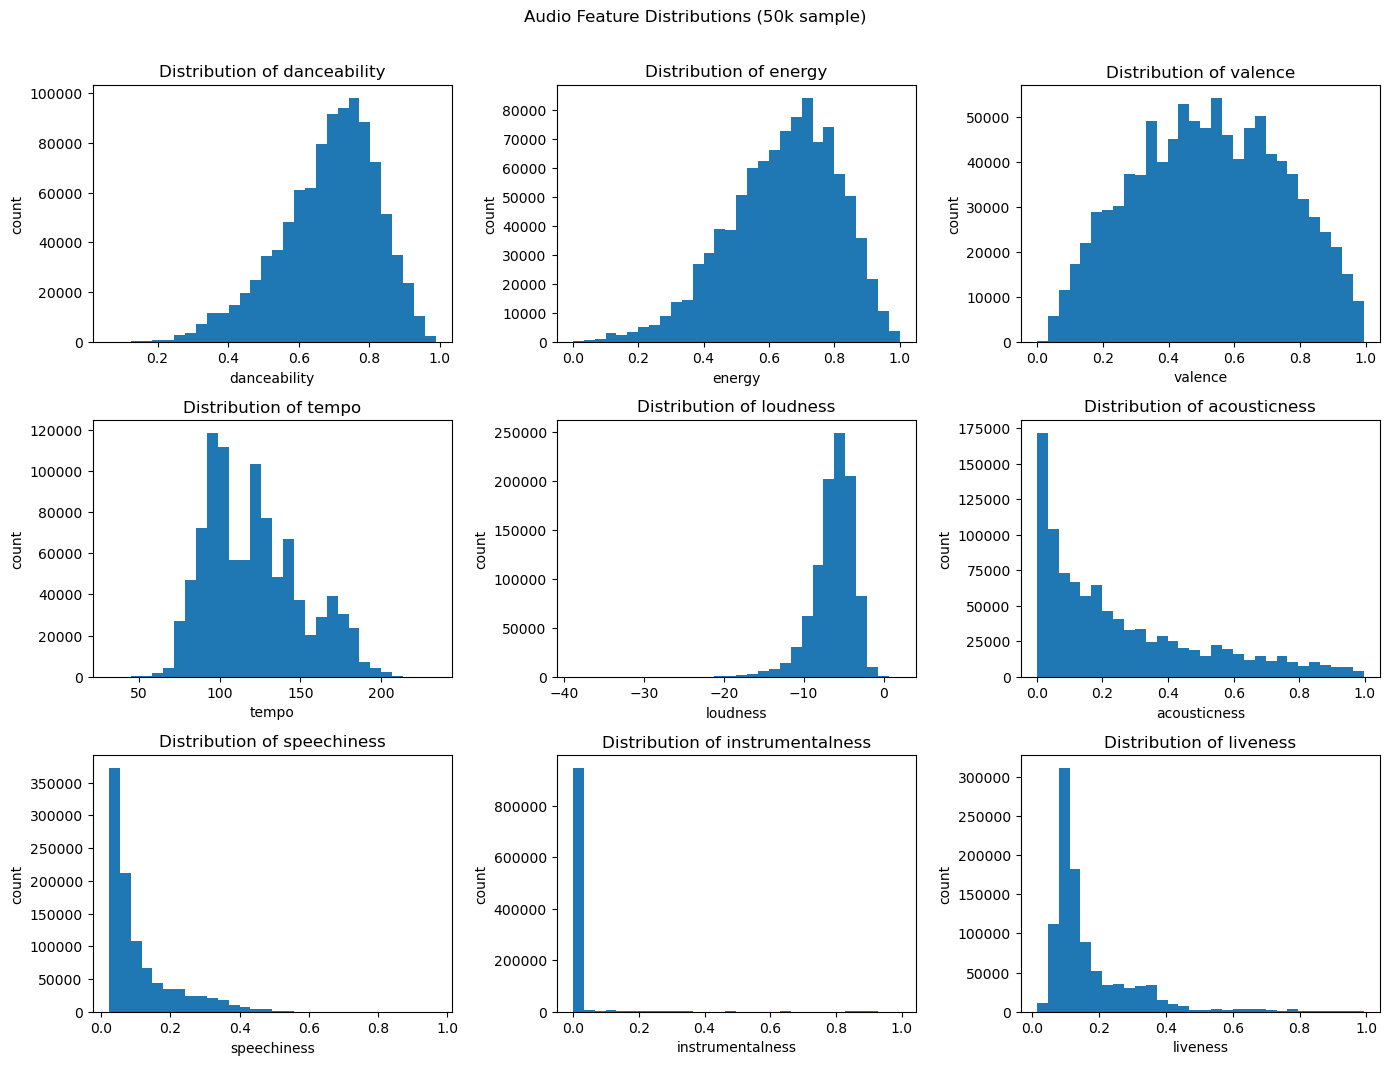

In [46]:
# Histograms of all numeric audio features 
audio_features = ["danceability", "energy", "valence", "tempo",
                   "loudness", "acousticness", "speechiness",
                   "instrumentalness", "liveness"]

n_cols = 3
n_rows = (len(audio_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    data = sample_df[feat].dropna()
    axes[i].hist(data, bins=30, edgecolor="none")
    axes[i].set_title(f"Distribution of {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("count")

# Hide unused axes
for j in range(len(audio_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Audio Feature Distributions (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


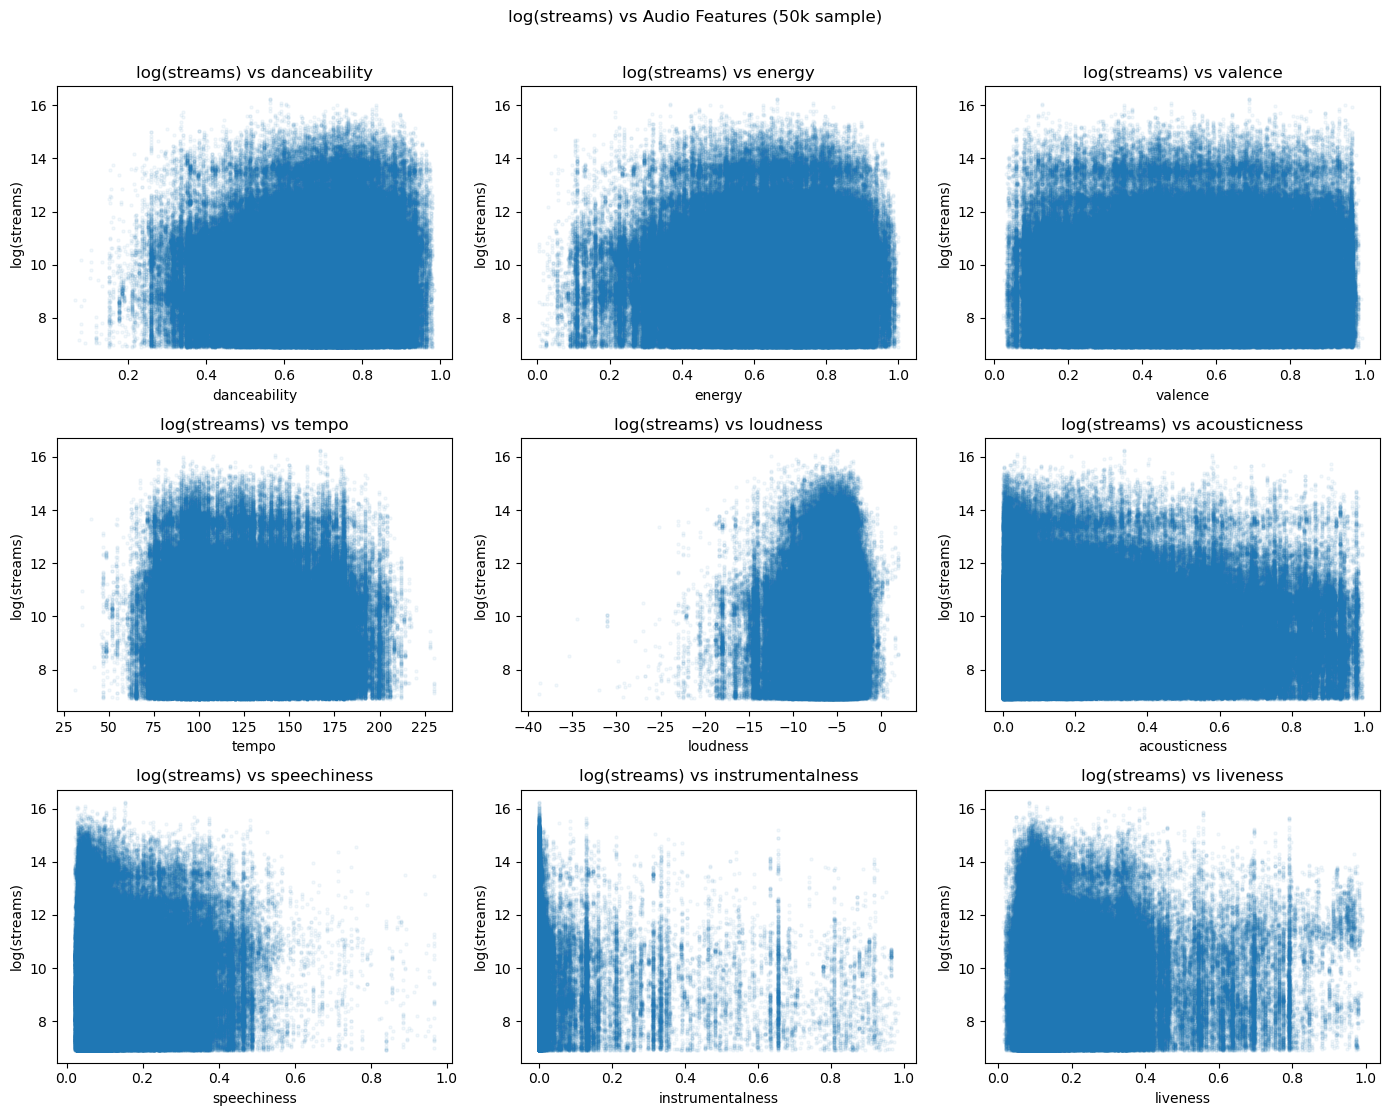

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(14, 11))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    x = sample_df[feat].dropna()
    y = sample_df.loc[x.index, "log_streams"].dropna()
    common = x.index.intersection(y.index)
    axes[i].scatter(x[common], y[common], alpha=0.05, s=5)
    axes[i].set_title(f"log(streams) vs {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("log(streams)")

plt.suptitle("log(streams) vs Audio Features (50k sample)", y=1.01)
plt.tight_layout()
plt.show()

### 8.5 Correlation

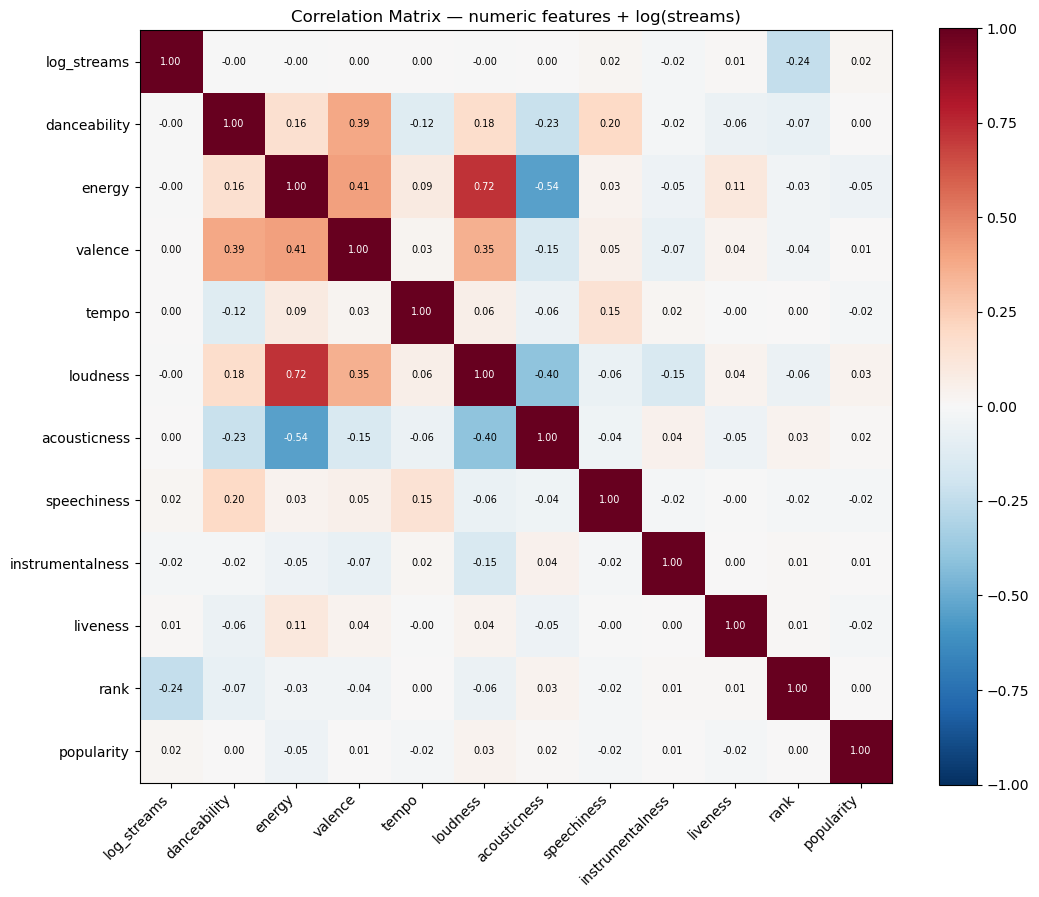


Correlations with log(streams) (sorted):
rank               -0.236714
popularity          0.022908
instrumentalness   -0.018076
speechiness         0.015899
liveness            0.013965
valence             0.004235
tempo               0.003558
energy             -0.002159
loudness           -0.001525
danceability       -0.000677
acousticness        0.000499


In [48]:
corr_df = con.execute("""
    SELECT
        LN(TRY_CAST(streams        AS DOUBLE)) AS log_streams,
        TRY_CAST(af_danceability   AS DOUBLE)  AS danceability,
        TRY_CAST(af_energy         AS DOUBLE)  AS energy,
        TRY_CAST(af_valence        AS DOUBLE)  AS valence,
        TRY_CAST(af_tempo          AS DOUBLE)  AS tempo,
        TRY_CAST(af_loudness       AS DOUBLE)  AS loudness,
        TRY_CAST(af_acousticness   AS DOUBLE)  AS acousticness,
        TRY_CAST(af_speechiness    AS DOUBLE)  AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness       AS DOUBLE)  AS liveness,
        TRY_CAST(rank              AS DOUBLE)  AS rank,
        TRY_CAST(popularity        AS DOUBLE)  AS popularity
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND TRY_CAST(streams AS DOUBLE) > 0
    USING SAMPLE 50000
""").df()

corr = corr_df.dropna().corr()

fig, ax = plt.subplots(figsize=(11, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(im, ax=ax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=7,
                color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

ax.set_title("Correlation Matrix — numeric features + log(streams)")
plt.tight_layout()
plt.show()

print("\nCorrelations with log(streams) (sorted):")
print(corr["log_streams"].drop("log_streams").sort_values(key=abs, ascending=False).to_string())


## 9. Split + Preprocess (without data leakage)
- Identify numeric and categorical features
- Build a `Pipeline` with `StandardScaler` for numeric and `OneHotEncoder` for categorical
- Perform a **75 / 25 train / test split** (`random_state=42`)

Because the full 26M-row dataset cannot fit into pandas memory, we use the **50k random sample**
already pulled in section 8. This gives a realistic and reproducible modelling baseline.

**Why a pipeline?**
- Prevents *data leakage* (scaler / encoder is fit only on train data during `.fit()`)
- Makes cross-validation safe and straightforward


In [57]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ── Define features and target ──
TARGET = "log_streams"

NUMERIC_FEATURES = [
    "danceability", "energy", "valence", "tempo",
    "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "popularity"
]
CATEGORICAL_FEATURES = ["chart", "explicit", "country_continent"]

# Drop rows where target or any feature is missing
model_df = sample_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET]].dropna()
print(f"Modelling sample after dropping NaNs: {model_df.shape}")

X = model_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = model_df[TARGET]

# ── Build preprocessing pipeline ──
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# ── Train / test split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape}  Test size: {X_test.shape}")


Modelling sample after dropping NaNs: (748625, 14)
Train size: (561468, 13)  Test size: (187157, 13)


## 10. Split + Preprocess (without data leakage)
- Identify numeric and categorical features
- Build a `Pipeline` with `StandardScaler` for numeric and `OneHotEncoder` for categorical
- Perform a **75 / 25 train / test split** (`random_state=42`)

Because the full 26M-row dataset cannot fit into pandas memory, we use the **50k random sample**
already pulled in section 8. This gives a realistic and reproducible modelling baseline.

**Why a pipeline?**
- Prevents *data leakage* (scaler / encoder is fit only on train data during `.fit()`)
- Makes cross-validation safe and straightforward


In [63]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ── Define features and target ──
TARGET = "log_streams"

NUMERIC_FEATURES = [
    "danceability", "energy", "valence", "tempo",
    "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "popularity"
]
CATEGORICAL_FEATURES = ["chart", "explicit", "country_continent"]

# Drop rows where target or any feature is missing
model_df = sample_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET]].dropna()
print(f"Modelling sample after dropping NaNs: {model_df.shape}")

X = model_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = model_df[TARGET]

# ── Build preprocessing pipeline ──
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# ── Train / test split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape}  Test size: {X_test.shape}")


Modelling sample after dropping NaNs: (37403, 14)
Train size: (28052, 13)  Test size: (9351, 13)


## 11. Baseline: Linear Regression

We fit a standard **least-squares linear regression**
and evaluate with:

- **RMSE** (in log-streams units)
- **R²** (fraction of variance explained)

**Checkpoint (think about these before running the next cell):**
- What does RMSE mean here if our target is `log(streams)`?
- What R² would you consider "good" for streaming data?


In [64]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ── Fit linear regression pipeline ──
lr_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

lr_pipe.fit(X_train, y_train)

# ── Predictions ──
y_train_pred = lr_pipe.predict(X_train)
y_test_pred  = lr_pipe.predict(X_test)

# ── Metrics ──
print("=== Linear Regression — Train ===")
print(f"  RMSE : {rmse(y_train, y_train_pred):.4f}")
print(f"  R²   : {r2_score(y_train, y_train_pred):.4f}")

print("\n=== Linear Regression — Test ===")
print(f"  RMSE : {rmse(y_test, y_test_pred):.4f}")
print(f"  R²   : {r2_score(y_test, y_test_pred):.4f}")

# ── Cross-validation on train set ──
cv_r2 = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring="r2")
print(f"\n5-fold CV R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


=== Linear Regression — Train ===
  RMSE : 1.4226
  R²   : 0.0428

=== Linear Regression — Test ===
  RMSE : 1.4325
  R²   : 0.0425

5-fold CV R²: 0.0416 ± 0.0030

5-fold CV R²: 0.0416 ± 0.0030


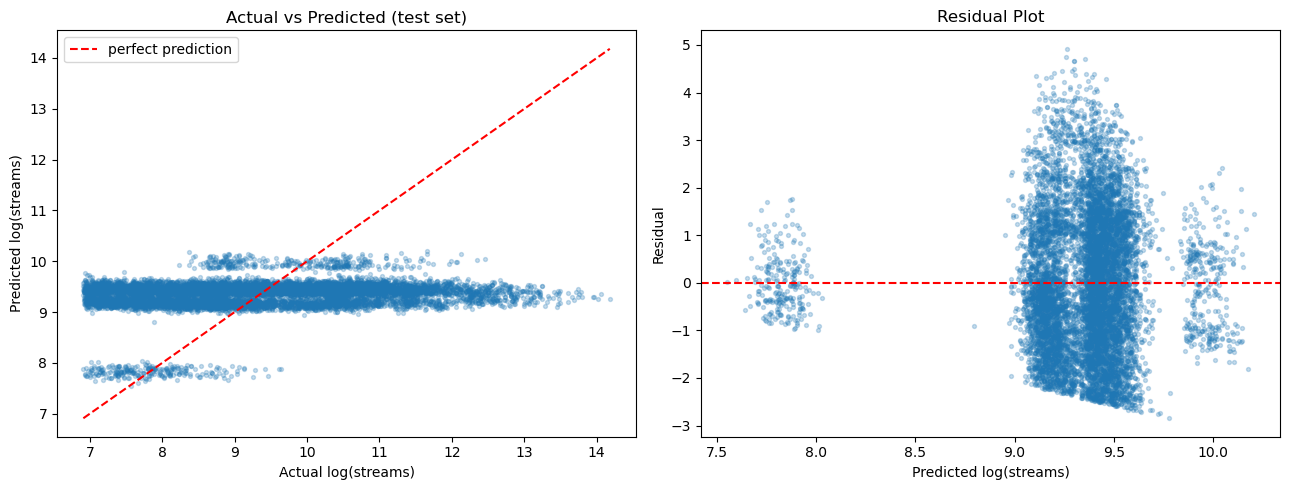

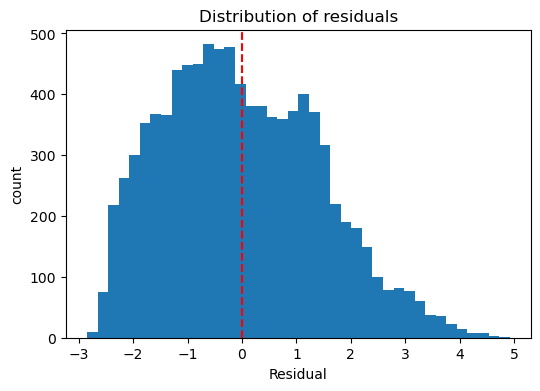

In [65]:
# ── Actual vs Predicted — diagnostic plot ──
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.25, s=8)
lo = min(y_test.min(), y_test_pred.min())
hi = max(y_test.max(), y_test_pred.max())
axes[0].plot([lo, hi], [lo, hi], "r--", lw=1.5, label="perfect prediction")
axes[0].set_xlabel("Actual log(streams)")
axes[0].set_ylabel("Predicted log(streams)")
axes[0].set_title("Actual vs Predicted (test set)")
axes[0].legend()

# Residuals
residuals = y_test.values - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.25, s=8)
axes[1].axhline(0, color="red", lw=1.5, linestyle="--")
axes[1].set_xlabel("Predicted log(streams)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

plt.tight_layout()
plt.show()

# Residual distribution
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, edgecolor="none")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of residuals")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()

## 14. Coefficient Inspection

statsmodels OLS summary. We extract the linear regression coefficients
to understand which features drive the model.


Top 15 most influential features (by |coefficient|):


,feature,coefficient,abs_coefficient
14,country_continent_Oceania,2.133003,2.133003
12,country_continent_Europe,1.646520,1.646520
15,country_continent_South America,1.641400,1.641400
13,country_continent_North America,1.421170,1.421170
11,country_continent_Asia,1.341493,1.341493
10,explicit_True,0.101326,0.101326
4,loudness,-0.038261,0.038261
0,danceability,-0.033641,0.033641
2,valence,0.024103,0.024103
8,liveness,0.019266,0.019266



Model Intercept: 7.789197956967926


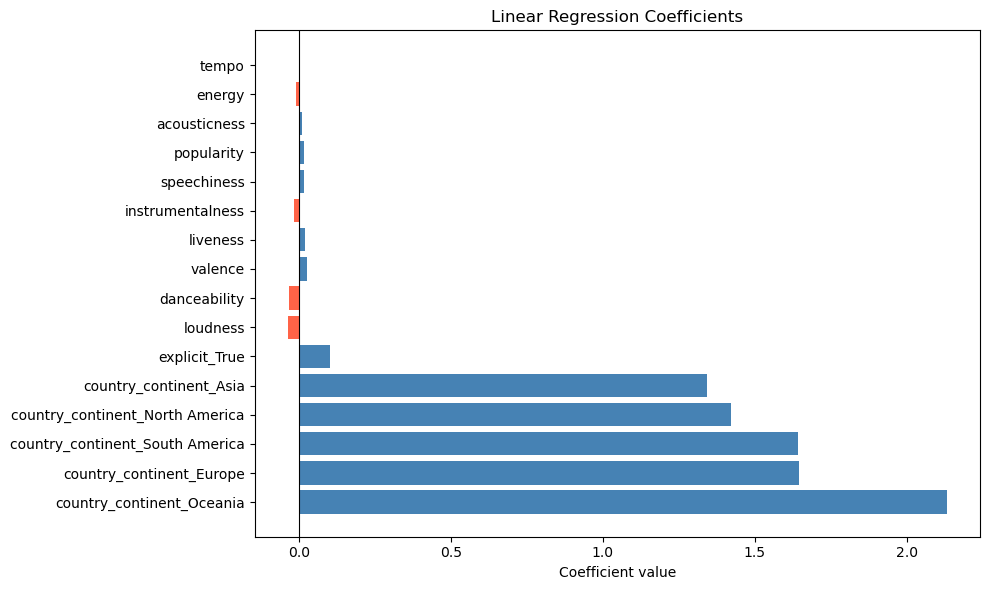

In [66]:
# Extract feature names after preprocessing
ohe_cats = lr_pipe.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(CATEGORICAL_FEATURES).tolist()
feature_names = NUMERIC_FEATURES + ohe_cats

# Create DataFrame with normal and absolute coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lr_pipe.named_steps["model"].coef_,
})
# Calculate the absolute value of the coefficients
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

# Sort by absolute value and display the top 15
coef_df = coef_df.sort_values("abs_coefficient", ascending=False)
print("Top 15 most influential features (by |coefficient|):")
display(coef_df.head(15))

# Extract and print the model intercept
intercept = lr_pipe.named_steps["model"].intercept_
print(f"\nModel Intercept: {intercept}")

# Bar chart of all coefficients
fig, ax = plt.subplots(figsize=(10, 6))
# Ensure chart remains sorted by influence for readability
colors = ["steelblue" if c >= 0 else "tomato" for c in coef_df["coefficient"]]
ax.barh(coef_df["feature"], coef_df["coefficient"], color=colors)
ax.axvline(0, color="black", lw=0.8)
ax.set_title("Linear Regression Coefficients")
ax.set_xlabel("Coefficient value")
plt.tight_layout()
plt.show()

### Interpreting the linear model coefficients (what increases/decreases predictions)

**Rule:**  
- **Positive coefficient (+)** → increases the prediction  
- **Negative coefficient (−)** → decreases the prediction  
- For **dummy variables** (e.g., `country_continent_Europe`), the coefficient is the effect **relative to the omitted reference category** (the continent that has no dummy).

### If the target is `log(streams)` (as in our EDA)
Then coefficients are easiest to read as **multiplicative / % effects**:

- A coefficient **β** corresponds to multiplying streams by **exp(β)**  
- Approx. percent change: **(exp(β) − 1) × 100%**

### Which variables increase predictions?
Largest positive effects (vs. reference continent):
- `country_continent_Oceania` **(+2.059)** → exp(2.059) ≈ **7.84×** (≈ **+684%**)
- `country_continent_South America` **(+1.618)** → ≈ **5.05×** (≈ **+405%**)
- `country_continent_Europe` **(+1.600)** → ≈ **4.95×** (≈ **+395%**)
- `country_continent_North America` **(+1.482)** → ≈ **4.40×** (≈ **+340%**)
- `country_continent_Asia` **(+1.267)** → ≈ **3.55×** (≈ **+255%**)

Other positive effects:
- `explicit_True` **(+0.086)** → exp(0.086) ≈ **1.09×** (≈ **+9%**)
- Small positives: `acousticness`, `liveness`, `valence`, `tempo`, `popularity`, `energy`

### Which variables decrease predictions?
- `danceability` **(−0.027)**
- `instrumentalness` **(−0.021)**
- `loudness` **(−0.020)**

(If the target is log(streams), β = −0.027 means exp(−0.027) ≈ **0.973×** → about **−2.7%** for a +1 unit change in that feature.)

### Are effects large or small?
- **Very large:** the **continent dummies** (coefficients ~1.3–2.1) dominate the model → they change predictions by **multiples**.
- **Medium:** `explicit_True` (~0.086) → around **single-digit %** effect.
- **Small:** most audio features have |β| around **0.02–0.03** (small changes in predicted log(streams)).

 Important: comparing “importance” by |coefficient| only makes sense if features are on **similar scales** (e.g., standardized). If not standardized, coefficient size also reflects the feature’s units (tempo in BPM, popularity 0–100, etc.).

### Are signs intuitive?
- **Instrumentalness negative**: intuitive (instrumentals often stream less in mainstream charts).
- **Popularity positive**: intuitive.
- **Continent effects**: plausible (differences in market size / Spotify usage / chart mechanics), but not causal.
- **Danceability negative / loudness negative**: might be counterintuitive and can depend on **scaling**, omitted variables, or correlations among features (multicollinearity). These signs should be discussed as “associations,” not causal effects.

**Intercept:** 7.83 means the baseline prediction (when all features = 0 and the reference categories apply) is **log(streams)=7.83** (streams ≈ exp(7.83) ≈ 2,517), but this baseline may not be realistic if “0” is outside typical feature values.


## 15. Regularization: Ridge | Lasso | ElasticNet

### Why Regularization?
Real datasets often have:
- Multicollinearity (e.g. energy and loudness are correlated)
- Noise
- Many one-hot-encoded dummy features

**Ridge** adds an L2 penalty to shrink all coefficients; **Lasso** adds an L1 penalty and can zero out irrelevant features.
Both reduce overfitting and improve generalization.**ElasticNet** is a modebel which behaves like Ridge (stable) + Lasso (some selection)
,especially good when predictors are correlated and you want interpretability.

In [67]:
rows = []

ridge_alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
enet_alphas  = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios    = [0.2, 0.5, 0.8]

# --- LinearRegression ---
pipe = Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
pipe.fit(X_train, y_train)
rows.append({
    "train_rmse": rmse(y_train, pipe.predict(X_train)),
    "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
    "train_r2":   r2_score(y_train, pipe.predict(X_train)),
    "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
    "model":      "LinearRegression",
    "alpha":      np.nan
})

# --- Ridge ---
for a in ridge_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=a))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Ridge",
        "alpha":      a
    })

# --- Lasso ---
for a in lasso_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=a, max_iter=20000))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Lasso",
        "alpha":      a
    })

# --- ElasticNet (encode l1_ratio into model name so column isn't needed) ---
for a in enet_alphas:
    for r in l1_ratios:
        pipe = Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=a, l1_ratio=r, max_iter=20000))])
        pipe.fit(X_train, y_train)
        rows.append({
            "train_rmse": rmse(y_train, pipe.predict(X_train)),
            "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
            "train_r2":   r2_score(y_train, pipe.predict(X_train)),
            "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
            "model":      f"ElasticNet(r={r})",
            "alpha":      a
        })

results_df = pd.DataFrame(rows)
results_df[["train_rmse","test_rmse","train_r2","test_r2"]] = results_df[["train_rmse","test_rmse","train_r2","test_r2"]].round(6)
results_df["alpha"] = results_df["alpha"].round(6)

results_df = results_df.sort_values(["test_rmse", "test_r2"], ascending=[True, False]).reset_index(drop=True)
display(results_df)

,train_rmse,test_rmse,train_r2,test_r2,model,alpha
0,1.422554,1.432477,0.042821,0.042552,Ridge,1.0000
1,1.422557,1.432479,0.042817,0.042550,Lasso,0.0001
2,1.422553,1.432480,0.042823,0.042549,Ridge,0.1000
3,1.422553,1.432480,0.042823,0.042548,LinearRegression,NaN
4,1.422553,1.432480,0.042823,0.042548,Ridge,0.0010
5,1.422553,1.432480,0.042823,0.042548,Ridge,0.0100
6,1.422669,1.432565,0.042667,0.042436,Ridge,10.0000
7,1.422954,1.432845,0.042283,0.042061,Lasso,0.0010
8,1.423017,1.432905,0.042197,0.041980,ElasticNet(r=0.8),0.0010
9,1.423112,1.432997,0.042071,0.041858,ElasticNet(r=0.5),0.0010


Best config per model family (by test RMSE):


,model,alpha,test_rmse,test_r2
0,ElasticNet(r=0.2),0.0010,1.433089,0.041734
1,ElasticNet(r=0.5),0.0010,1.432997,0.041858
2,ElasticNet(r=0.8),0.0010,1.432905,0.041980
3,Lasso,0.0001,1.432479,0.042550
4,LinearRegression,NaN,1.432480,0.042548
5,Ridge,1.0000,1.432477,0.042552


ElasticNet(r=0.2)  (alpha=0.001)
  CV RMSE per fold : [1.4299 1.4345 1.4013 1.4358 1.4186]
  Mean CV RMSE     : 1.4240
  Std  CV RMSE     : 0.0129

ElasticNet(r=0.5)  (alpha=0.001)
  CV RMSE per fold : [1.4298 1.4344 1.4012 1.4357 1.4185]
  Mean CV RMSE     : 1.4239
  Std  CV RMSE     : 0.0129

ElasticNet(r=0.5)  (alpha=0.001)
  CV RMSE per fold : [1.4298 1.4344 1.4012 1.4357 1.4185]
  Mean CV RMSE     : 1.4239
  Std  CV RMSE     : 0.0129

ElasticNet(r=0.8)  (alpha=0.001)
  CV RMSE per fold : [1.4297 1.4343 1.4011 1.4356 1.4184]
  Mean CV RMSE     : 1.4238
  Std  CV RMSE     : 0.0129

ElasticNet(r=0.8)  (alpha=0.001)
  CV RMSE per fold : [1.4297 1.4343 1.4011 1.4356 1.4184]
  Mean CV RMSE     : 1.4238
  Std  CV RMSE     : 0.0129

Lasso  (alpha=0.0001)
  CV RMSE per fold : [1.4293 1.4336 1.401  1.435  1.4179]
  Mean CV RMSE     : 1.4234
  Std  CV RMSE     : 0.0127

Lasso  (alpha=0.0001)
  CV RMSE per fold : [1.4293 1.4336 1.401  1.435  1.4179]
  Mean CV RMSE     : 1.4234
  Std  CV RMSE 

,model,alpha,cv_rmse_mean,cv_rmse_std,test_rmse,gap (cv - test)
0,Lasso,0.0001,1.4234,0.0127,1.432479,-0.0091
1,LinearRegression,NaN,1.4234,0.0127,1.432480,-0.0091
2,Ridge,1.0000,1.4234,0.0127,1.432477,-0.0091
3,ElasticNet(r=0.8),0.0010,1.4238,0.0129,1.432905,-0.0091
4,ElasticNet(r=0.5),0.0010,1.4239,0.0129,1.432997,-0.0091
5,ElasticNet(r=0.2),0.0010,1.4240,0.0129,1.433089,-0.0091


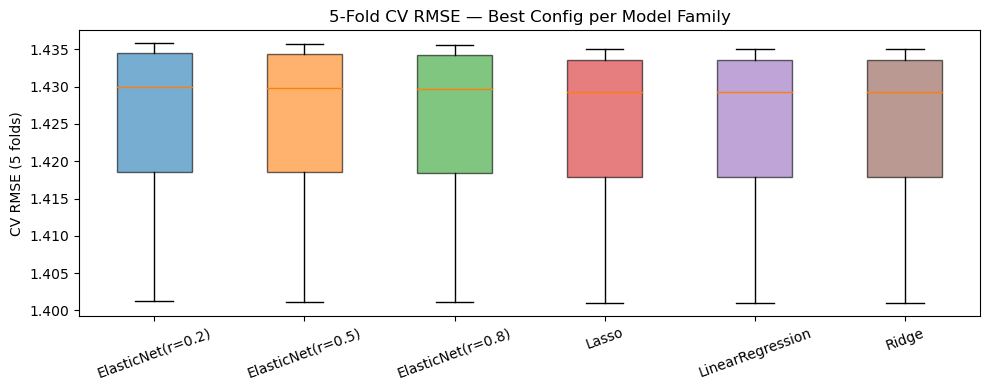

In [68]:
# ── Pick the best alpha per model family from the grid search ─────────────────
# We take the row with the lowest test_rmse for each model family.
# ElasticNet variants are grouped by their full name (which encodes l1_ratio).

best_configs = (
    results_df
    .loc[results_df.groupby("model")["test_rmse"].idxmin()]
    .reset_index(drop=True)
)
print("Best config per model family (by test RMSE):")
display(best_configs[["model", "alpha", "test_rmse", "test_r2"]])

# Build the winning pipelines
def build_pipe(model_name: str, alpha: float) -> Pipeline:
    if model_name == "LinearRegression":
        return Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
    elif model_name == "Ridge":
        return Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=alpha))])
    elif model_name == "Lasso":
        return Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=alpha, max_iter=20000))])
    elif model_name.startswith("ElasticNet"):
        # parse l1_ratio from the encoded name, e.g. "ElasticNet(r=0.5)"
        l1 = float(model_name.split("r=")[1].rstrip(")"))
        return Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=20000))])
    else:
        raise ValueError(f"Unknown model: {model_name}")

# 5-fold CV on the BEST config per family
# cross_val_score returns *negative* RMSE → multiply by -1

cv_rows = []

for _, row in best_configs.iterrows():
    name  = row["model"]
    alpha = row["alpha"]
    pipe  = build_pipe(name, alpha)

    neg_rmse_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    rmse_scores = -neg_rmse_scores

    cv_rows.append({
        "model":          name,
        "alpha":          alpha,
        "cv_rmse_mean":   round(rmse_scores.mean(), 4),
        "cv_rmse_std":    round(rmse_scores.std(),  4),
        "fold_scores":    rmse_scores.round(4).tolist(),
        "test_rmse":      row["test_rmse"],   # from grid search — for comparison
    })

    print(f"{name}  (alpha={alpha})")
    print(f"  CV RMSE per fold : {rmse_scores.round(4)}")
    print(f"  Mean CV RMSE     : {rmse_scores.mean():.4f}")
    print(f"  Std  CV RMSE     : {rmse_scores.std():.4f}")
    print()

# ── Summary table ─────────────────────────────────────────────────────────────
cv_summary = pd.DataFrame(cv_rows).sort_values("cv_rmse_mean").reset_index(drop=True)
cv_summary["gap (cv - test)"] = (cv_summary["cv_rmse_mean"] - cv_summary["test_rmse"]).round(4)
print("CV summary (sorted by Mean CV RMSE):")
display(cv_summary[["model", "alpha", "cv_rmse_mean", "cv_rmse_std", "test_rmse", "gap (cv - test)"]])

# ── Boxplot: CV RMSE spread per winning model ─────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
labels = [r["model"] for r in cv_rows]
data   = [r["fold_scores"] for r in cv_rows]
bp = ax.boxplot(data, labels=labels, patch_artist=True)

colors = plt.cm.tab10.colors
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel("CV RMSE (5 folds)")
ax.set_title("5-Fold CV RMSE — Best Config per Model Family")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()

## 16. Gradient Descent — From Scratch



This section is for *conceptual reinforcement*. We re-implement linear regression
using **batch gradient descent** on the same preprocessed design matrix, then compare
results to sklearn's closed-form solution.

**How it works:**
1. Start with `θ = 0` (all-zero coefficients)
2. Compute predictions: `ŷ = X · θ`
3. Compute gradient of MSE: `∇ = (2/m) · Xᵀ(ŷ − y)`
4. Update: `θ ← θ − lr · ∇`
5. Repeat for `n_iter` steps

**Checkpoint (think about these before running):**
- What happens if the learning rate `lr` is too high? Too low?
- How do we know we've converged?
- Why must features be standardised before gradient descent?

## Why Gradient Descent Matters
This section shows *how* models learn under the hood:
- Start with random / zero coefficients
- Iteratively reduce the training error
- Converge toward the optimal solution

Focus on the concept — not every line of maths.


In [69]:
# ── Step 1: Extract the preprocessed design matrix ──────────────────────────
# Reuse the already-fit preprocessor from lr_pipe (section 13)
# Refit here so this cell works even if run out of order
preprocess_fit = preprocess.fit(X_train)

X_train_gd = preprocess_fit.transform(X_train)
X_test_gd  = preprocess_fit.transform(X_test)

# Convert to dense if sparse
X_train_gd = X_train_gd.toarray() if hasattr(X_train_gd, "toarray") else X_train_gd
X_test_gd  = X_test_gd.toarray()  if hasattr(X_test_gd,  "toarray") else X_test_gd

# ── Step 2: Prepend intercept column (column of 1s) ──────────────────────────
X_train_gd = np.c_[np.ones(X_train_gd.shape[0]), X_train_gd]
X_test_gd  = np.c_[np.ones(X_test_gd.shape[0]),  X_test_gd]

print(f"X_train_gd shape: {X_train_gd.shape}  (includes intercept column)")
print(f"X_test_gd  shape: {X_test_gd.shape}")


X_train_gd shape: (28052, 17)  (includes intercept column)
X_test_gd  shape: (9351, 17)


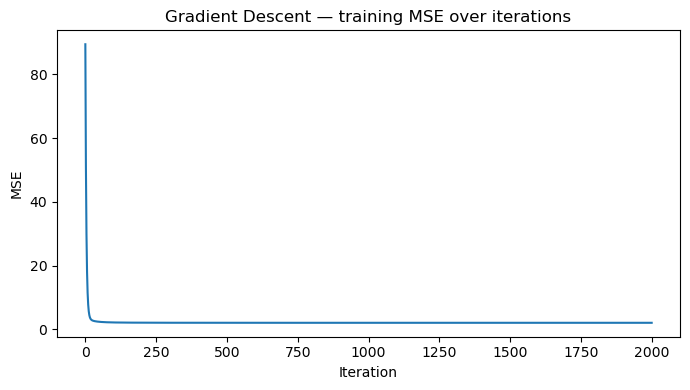

In [70]:
# ── Step 3: Gradient Descent implementation ──────────────────────────────────
def gradient_descent(X, y, lr=0.05, n_iter=2000):
    """Batch gradient descent for linear regression (MSE loss).

    Parameters
    ----------
    X      : (m, n+1) design matrix with intercept column prepended
    y      : (m,) target vector
    lr     : learning rate
    n_iter : number of gradient steps

    Returns
    -------
    theta   : (n+1,) learned coefficient vector
    history : (n_iter,) MSE at each iteration
    """
    theta = np.zeros(X.shape[1])  # initialise all weights at 0
    m = X.shape[0]
    history = []
    for _ in range(n_iter):
        y_pred = X @ theta                          # forward pass
        grad   = (2 / m) * (X.T @ (y_pred - y))    # gradient of MSE
        theta -= lr * grad                          # weight update
        history.append(mean_squared_error(y, y_pred))
    return theta, np.array(history)


theta_gd, mse_hist = gradient_descent(
    X_train_gd, y_train.values, lr=0.05, n_iter=2000
)

# ── Step 4: Plot training MSE convergence ────────────────────────────────────
plt.figure(figsize=(7, 4))
plt.plot(mse_hist, lw=1.5)
plt.title("Gradient Descent — training MSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()


Model                              RMSE       R²
---------------------------------------------
sklearn LinearRegression         1.4325   0.0425
Gradient Descent (lr=0.05, 2000 iters)   1.4325   0.0425

Both should be very close — gradient descent converges to the same minimum.
If they differ, try increasing n_iter or decreasing lr.


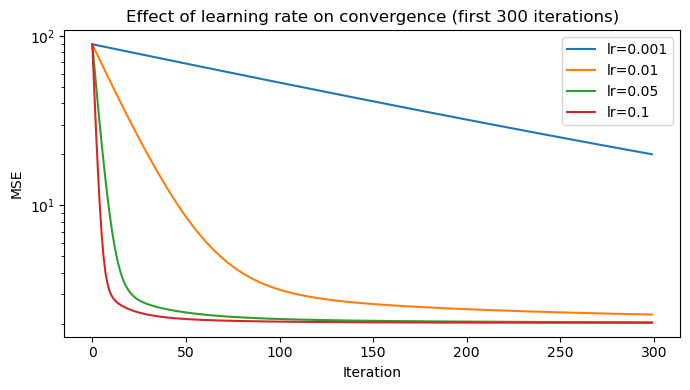

In [71]:
# ── Step 5: Evaluate on test set and compare to sklearn's closed-form ────────
y_test_pred_gd = X_test_gd @ theta_gd

rmse_gd = rmse(y_test, y_test_pred_gd)
r2_gd   = float(r2_score(y_test, y_test_pred_gd))

# Retrieve sklearn closed-form results from section 13
rmse_lr = rmse(y_test, y_test_pred)
r2_lr   = float(r2_score(y_test, y_test_pred))

print("=" * 45)
print(f"{'Model':<30} {'RMSE':>8} {'R²':>8}")
print("-" * 45)
print(f"{'sklearn LinearRegression':<30} {rmse_lr:>8.4f} {r2_lr:>8.4f}")
print(f"{'Gradient Descent (lr=0.05, 2000 iters)':<30} {rmse_gd:>8.4f} {r2_gd:>8.4f}")
print("=" * 45)
print("\nBoth should be very close — gradient descent converges to the same minimum.")
print("If they differ, try increasing n_iter or decreasing lr.")

# sensitivity to learning rate ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
for lr_val in [0.001, 0.01, 0.05, 0.1]:
    _, hist = gradient_descent(X_train_gd, y_train.values, lr=lr_val, n_iter=300)
    ax.plot(hist, label=f"lr={lr_val}")

ax.set_title("Effect of learning rate on convergence (first 300 iterations)")
ax.set_xlabel("Iteration")
ax.set_ylabel("MSE")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()
